# Preparations

In [3]:
import ast
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
plt.rcParams["figure.figsize"] = (8,6)

In [7]:
# Some parameters of the simulations to be analyzed
rounds = 50
vehicle_limit = 80

rate_range = np.arange(8,66,2)
target_number_of_rounds = 15

all_routes = [[0, 3], [0, 1], [2, 3], [2, 1]]
sub_routes = [[0, 1], [2, 3]]

## Preprocessing of `record`
The dataframe contains vehicle data recorded in each simulation round, including:
- the label assigned to each car (`Vehicle_label`)
- the routes taken (`Road_order`)
- the time spent to reach the end (`Total_time`)
- the label of the vehicle immediately in front of it in the corrdsponding road segment (`Leading_vehicles`)
- the amount of time it stopped (speed is 0) in the corresponding road segment (`Stopped_time`)

In [22]:
def preprocess_record(record, routes):
    # Since some column values are lists, they need to be preprocessed after importing the csv file to
    # avoid the lists being recognized as strings
    record['Road_order'] = record.apply(lambda row: ast.literal_eval(row['Road_order']), axis=1)

    # Add a column that maps a specific road combination (i.e., a route) to a "label", which is its position
    # in a list that shows all the possible routes
    record["Road_order_label"] = record.apply(lambda row: routes.index(row.Road_order), axis=1)
    return record

## Preprocessing of `utility`
The dataframe contains utility data computed based on the simulation outcome, including:
- the label assigned to each car (`Vehicle_label`)
- the utility value of each route as a list element (`Utilities`)
- the probability value of choosing each route in the next round as a list element (`Probabilities`)
- all the routes each car has chosen so far (`Routes_taken`)
- the interpolation between time and money for the driver (`Gamma`) for computing the time component of the utility value
- the risk aversion level of the driver (`Eta`) for deciding the formula of utility calculation

In [23]:
def preprocess_utility(utility):
    # Since some column values are lists, they need to be preprocessed after importing the csv file to
    # avoid the lists being recognized as strings
    utility['Routes_taken'] = utility.apply(lambda row: ast.literal_eval(row['Routes_taken']), axis=1)
    utility['Probabilities'] = utility.apply(lambda row: ast.literal_eval(row['Probabilities']), axis=1)
    return utility

## Functions needed

In [55]:
def avg_total_time(df, target_number_of_rounds, rounds):
    """
    Computes the average total time spent by all vehicles per round for 
    the last n rounds. (n is specified in the function input)
    
    Parameters:
        df (pd.DataFrame): dataframe that records vehicle-specific data of all
                           rounds in a simulation run
        target_number_of_rounds (integer): how many rounds to be considered in
                                           the average time calculation
        rounds (integer): total number of rounds
    """
    
    pivot_df = pd.pivot_table(df, values='Total_time', 
                              index='Round_number', 
                              aggfunc=np.sum).reset_index(drop=False)
    return pivot_df.loc[pivot_df.Round_number>(rounds-target_number_of_rounds)].Total_time.mean()

In [56]:
def route_avg_time(ax, 
                   fig,
                   record_df, 
                   number_of_routes,
                   rate,
                   save_dir=None):
    """
    Plot the average time to arrive grouped by each route and round.
    """
    
    time_df = pd.pivot_table(record_df, values='Total_time', 
                             index=['Road_order_label', 'Round_number'], 
                             aggfunc=np.mean).reset_index(drop=False)
    plot_route_time = [[], [], [], []]

    for i in range(number_of_routes):
        times = time_df.loc[time_df.Road_order_label==i].sort_values('Round_number').Total_time.values
        plot_route_time[i]=times

    for i in range(number_of_routes):
        ax.plot(plot_route_time[i], label="Route "+str(i))

    ax.set_xlabel("Round")
    ax.set_ylabel("Average time to arrive")
#     ax.set_title(f"Average time needed to reach (Vehicle rate={rate})")
    ax.set_title(f"Vehicle rate={rate}")
#     plt.legend(bbox_to_anchor=(1, 0.5))
    
    if save_dir != None:
        fig.savefig(save_dir, bbox_inches = 'tight')
    
#     plt.show()
#     ax.legend()
    return ax

In [61]:
def route_taken_number(ax,
                       fig,
                       utility_df, 
                       rounds, 
                       number_of_routes, 
                       rate,
                       save_dir=None):
    """
    Plot the changes in number of vehicles that took the route over time.
    """
    
    route_df = pd.DataFrame(utility_df['Routes_taken'].to_list(), columns=range(rounds))
    plot_route_l = [[], [], [], []]

    for i in range(number_of_routes):
        for j in range(rounds):
            plot_route_l[i].append(len(route_df.loc[route_df[j]==i]))

    for i in range(number_of_routes):
        ax.plot(plot_route_l[i], label="Route "+str(i))
    
    ax.set_xlabel("Round")
    ax.set_ylabel("Number of vehicles choosing the route")
#     ax.set_title(f"Number of vehicles that choose a route over time (rate={rate})")
    ax.set_title(f"Vehicle rate={rate}")
#     plt.legend(bbox_to_anchor=(1, 0.5))
    
    if save_dir != None:
        fig.savefig(save_dir, bbox_inches = 'tight')
    
#     plt.show()
    return ax

In [62]:
def route_chosen_probability(ax,
                             fig,
                             rounds, 
                             number_of_routes, 
                             rate,
                             folder_name,
                             save_dir=None):
    """
    Plot the changes in probabilities of choosing each route over time.    
    """
    
    plot_prob_l = [[], [], [], []]

    for r in range(1, rounds+1):
        df = pd.read_csv(f'{folder_name}/Saved_data/Utility_data/{rate}/Round_{r}.csv')
        df['Probabilities'] = df.apply(lambda row: ast.literal_eval(row['Probabilities']), axis=1)
        for i in range(number_of_routes):
            avg_prob = pd.DataFrame(df['Probabilities'].to_list(), columns=range(number_of_routes))[i].mean()
            plot_prob_l[i].append(avg_prob)
            
    for i in range(number_of_routes):
        ax.plot(plot_prob_l[i], label="Route "+str(i))

    ax.set_xlabel("Round")
    ax.set_ylabel("Average probability of choosing the route")
#     ax.set_title(f"Average probability of choosing a route over time (rate={rate})")
    ax.set_title(f"Vehicle rate={rate}")
#     plt.legend(bbox_to_anchor=(1, 0.5))
    
    if save_dir != None:
        fig.savefig(save_dir, bbox_inches = 'tight')
    
#     plt.show()
    return ax

In [59]:
def total_utility(target_number_of_rounds, 
                  rounds, 
                  rate,
                  folder_name,
                  save_dir=None):
    
    """
    Plot and return the total utility values of all vehicles in each of the last few rounds.
    The number of rounds is specified by 'target_number_of_rounds'.
    """
    
    total_utilities = np.zeros((target_number_of_rounds))
    
    for r in range(rounds-target_number_of_rounds+1, rounds+1):
        df = pd.read_csv(f'{folder_name}/Saved_data/Utility_data/{rate}/Round_{r}.csv')
        df['Utilities'] = df.apply(lambda row: ast.literal_eval(row['Utilities']), axis=1)
        df['Routes_taken'] = df.apply(lambda row: ast.literal_eval(row['Routes_taken']), axis=1)
        
        for idx, row in df.iterrows():
            route_taken = row['Routes_taken'][-1]
            utility = row['Utilities'][route_taken]
            
            total_utilities[r-(rounds-target_number_of_rounds+1)] += utility
    
#     if ax and fig:
#         ax.plot(range(rounds-target_number_of_rounds+1, rounds+1), total_utilities)

#         ax.set_xlabel("Round")
#         ax.set_ylabel("Total utilities")
#         ax.set_title("Total utilities of all vehicles over time")

#         if save_dir != None:
#             fig.savefig(save_dir, bbox_inches = 'tight')

#         plt.show()
    
    return total_utilities

# Analysis

## - The average time needed to reach destination by different routes

### Zero alpha case

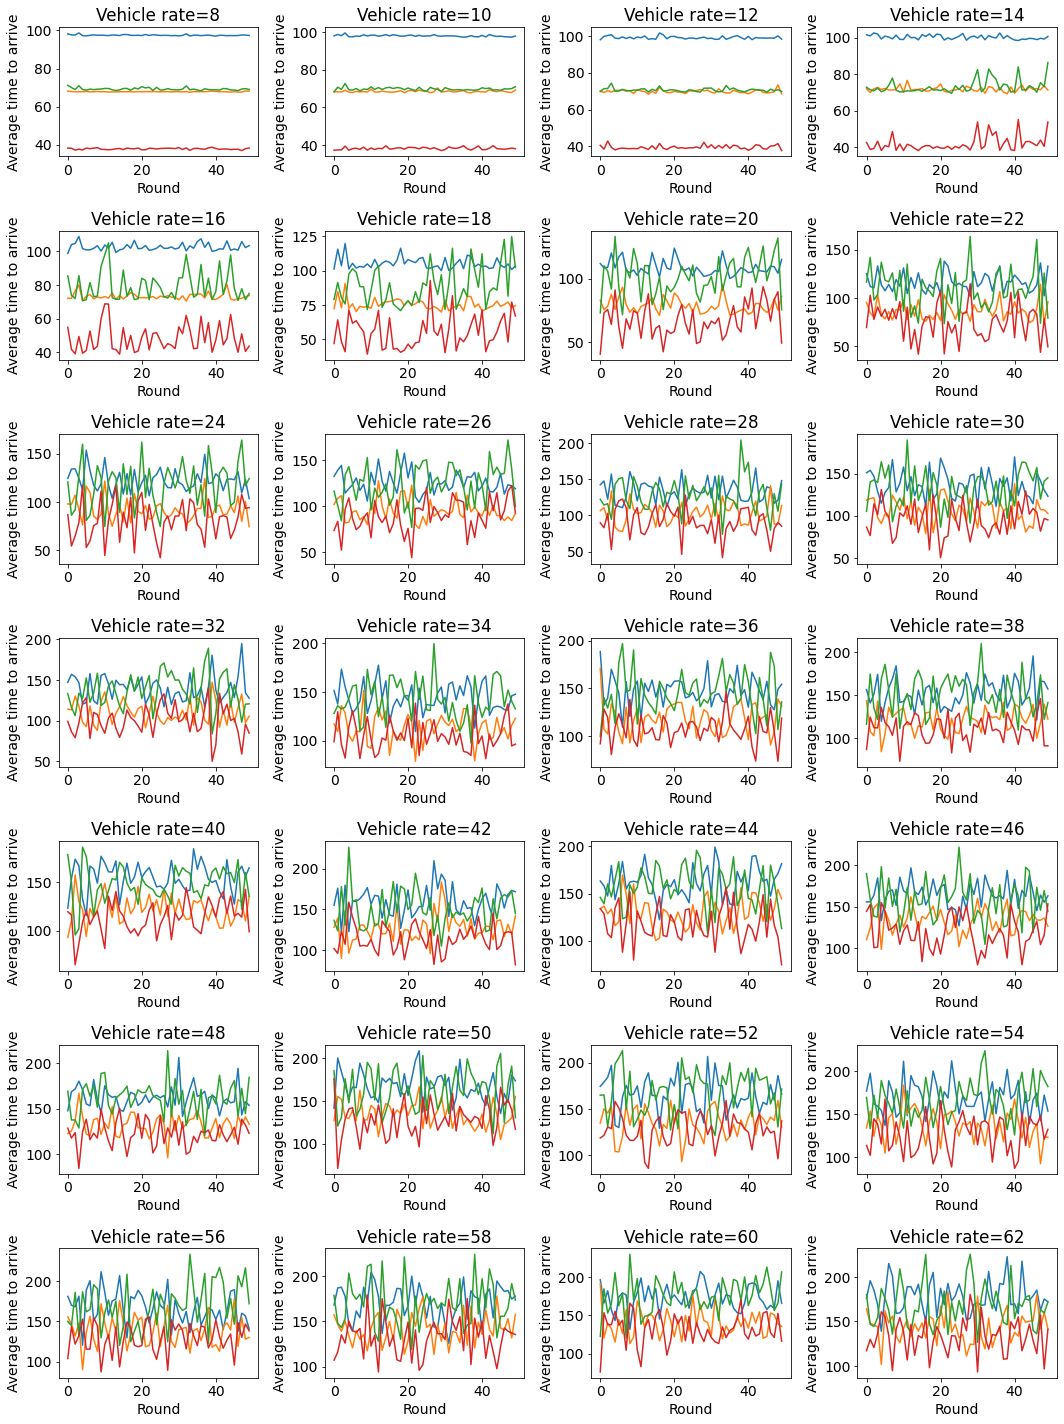

In [50]:
fig, axs = plt.subplots(7, 4, figsize=(15, 20))

for idx in range(len(rate_range)-1):
# for idx in range(3):
    i = rate_range[idx]
    record_df = pd.read_csv(f'1.1 Zero alpha/Saved_data/Simulation_records/VehicleRate_{i}_Round_{rounds}.csv')
    record_df = preprocess_record(record_df, all_routes)

    ax = route_avg_time(axs[idx//4, idx%4], 
                        fig,
                        record_df=record_df, 
                        number_of_routes=len(all_routes),
                        rate=i,
                       )
    axs[idx//4, idx%4] = ax

# plt.legend()
plt.tight_layout()
plt.show()

### No connection case

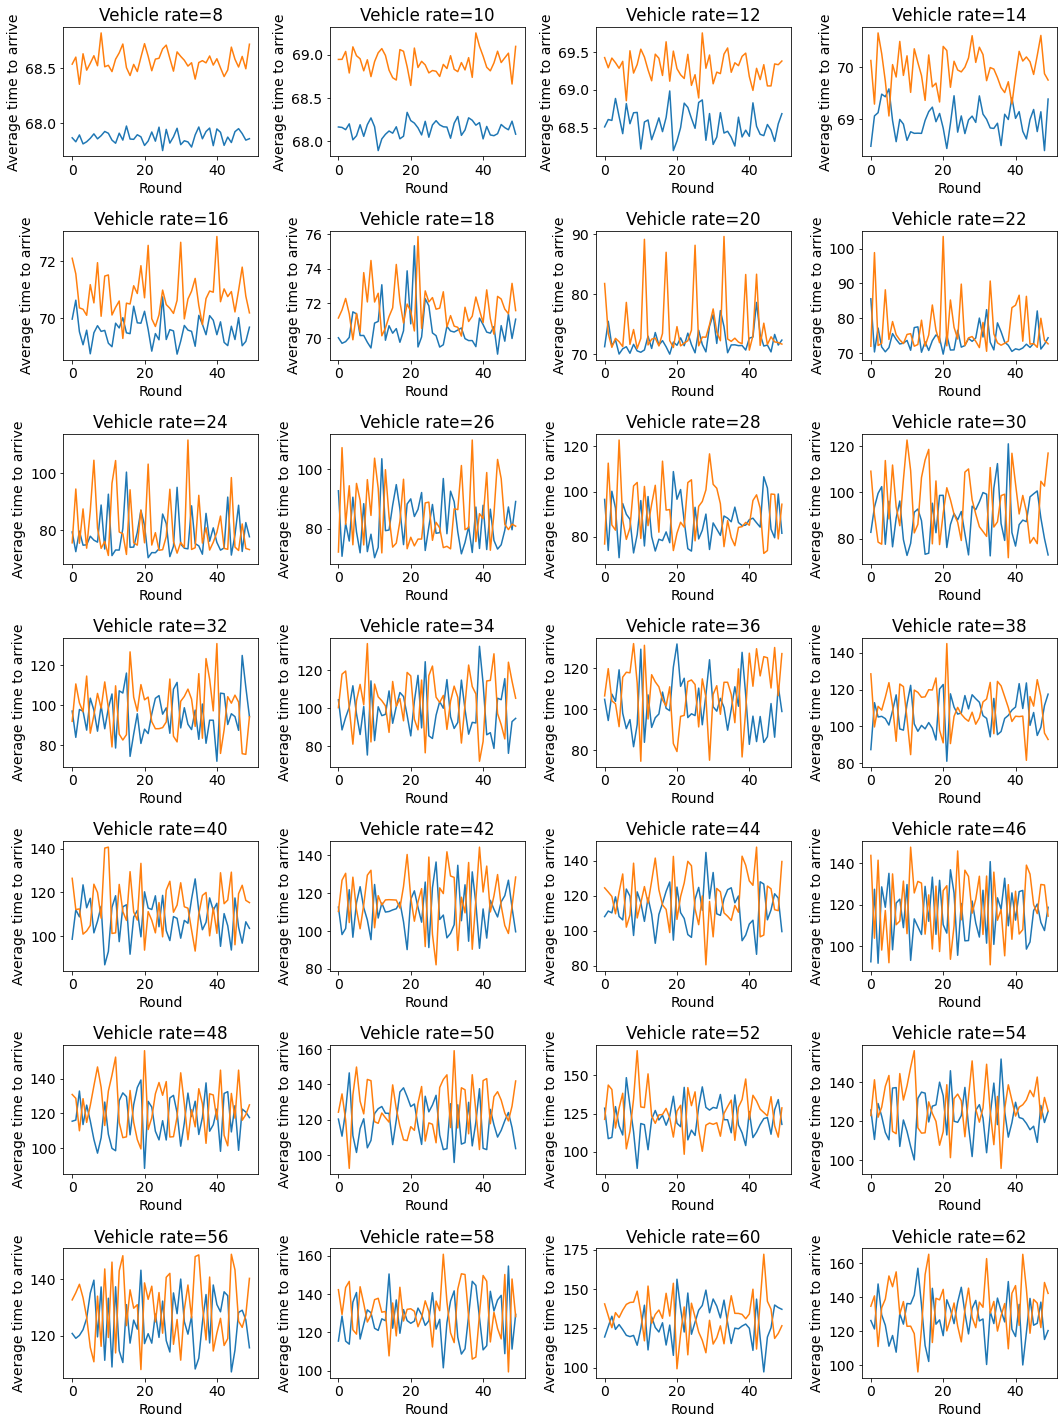

In [60]:
# for i in rate_range:
#     record_df = pd.read_csv(f'1.2 No connection/Saved_data/Simulation_records/VehicleRate_{i}_Round_{rounds}.csv')
#     record_df = preprocess_record(record_df, sub_routes)

#     fig1, ax1 = plt.subplots(figsize=(10, 6))

#     route_avg_time(ax1, 
#                    fig1,
#                    record_df=record_df, 
#                    number_of_routes=len(sub_routes),
#                    rate=i,
#     #                save_dir="Route_Avg_Time.png"
#                   )

fig2, axs2 = plt.subplots(7, 4, figsize=(15, 20))

for idx in range(len(rate_range)-1):
    i = rate_range[idx]
    record_df = pd.read_csv(f'1.2 No connection/Saved_data/Simulation_records/VehicleRate_{i}_Round_{rounds}.csv')
    record_df = preprocess_record(record_df, sub_routes)

    ax = route_avg_time(axs2[idx//4, idx%4], 
                       fig2,
                       record_df=record_df, 
                       number_of_routes=len(sub_routes),
                       rate=i,
                      )
    axs2[idx//4, idx%4] = ax

# plt.legend()
plt.tight_layout()
plt.show()

## - The number of vehicles that choose a route over time

### Zero alpha case

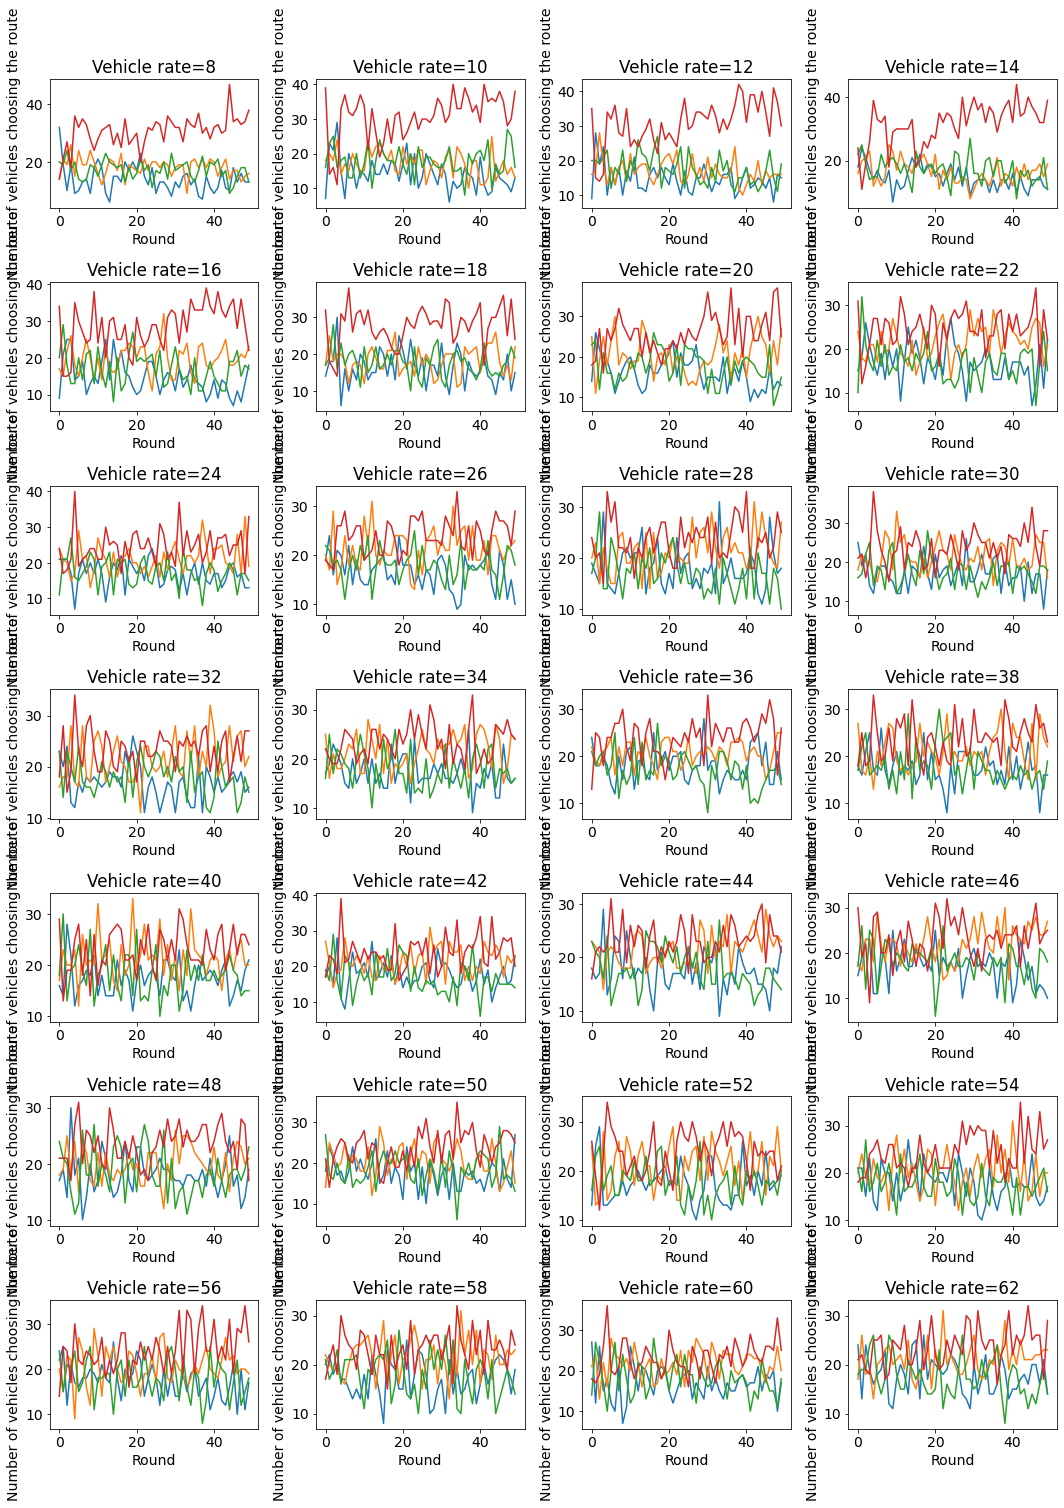

In [63]:
# for i in rate_range:
#     utility_df = pd.read_csv(f'1.1 Zero alpha/Saved_data/Utility_data/{i}/Round_{rounds}.csv')
#     utility_df = preprocess_utility(utility_df)

#     fig3, ax3 = plt.subplots(figsize=(10, 6))
    
#     route_taken_number(ax3, 
#                    fig3, 
#                    utility_df, 
#                    rounds, 
#                    len(all_routes),
#                    i,
# #                    save_dir="Route_Chosen_Times.png"
#                   )

fig3, axs3 = plt.subplots(7, 4, figsize=(15, 20))

for idx in range(len(rate_range)-1):
    i = rate_range[idx]
    utility_df = pd.read_csv(f'1.1 Zero alpha/Saved_data/Utility_data/{i}/Round_{rounds}.csv')
    utility_df = preprocess_utility(utility_df)
    
    ax = route_taken_number(axs3[idx//4, idx%4], 
                            fig3,
                            utility_df,
                            rounds, 
                            len(all_routes),
                            i
                           )
    axs3[idx//4, idx%4] = ax

# plt.legend()
plt.tight_layout()
plt.show()

### No connection case

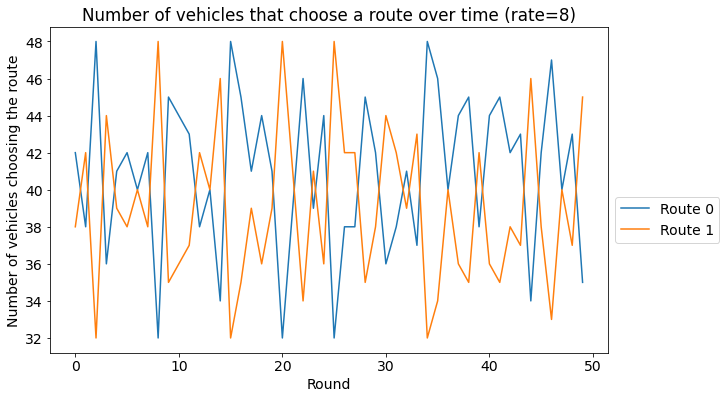

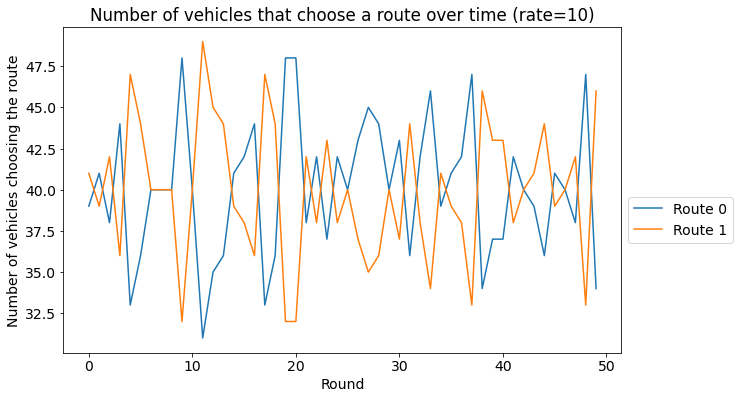

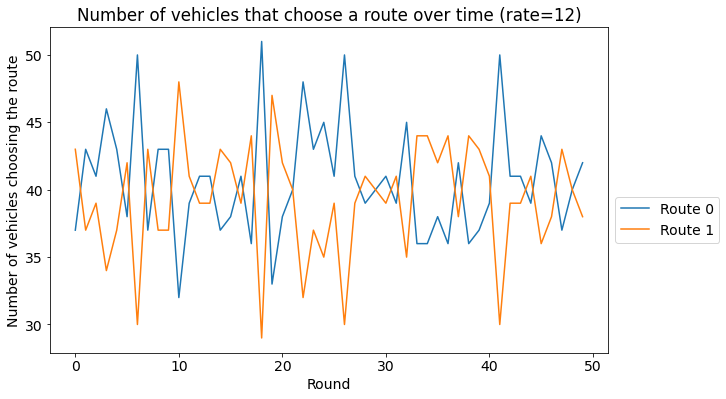

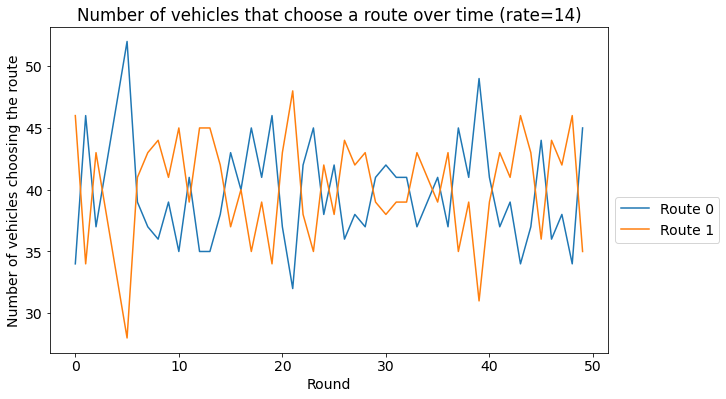

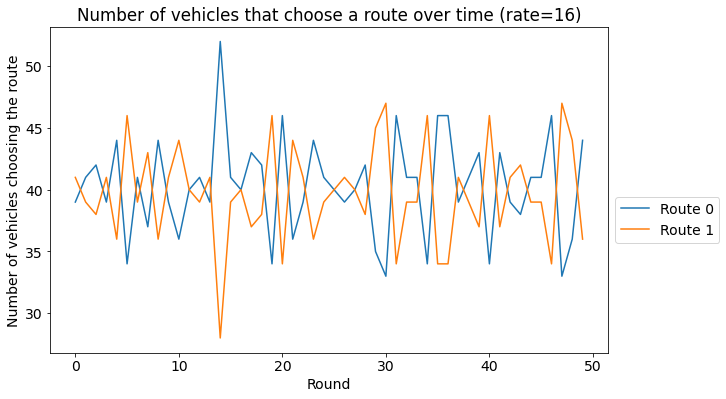

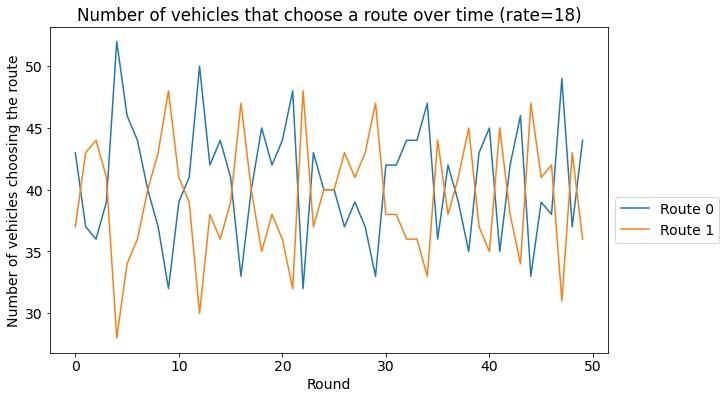

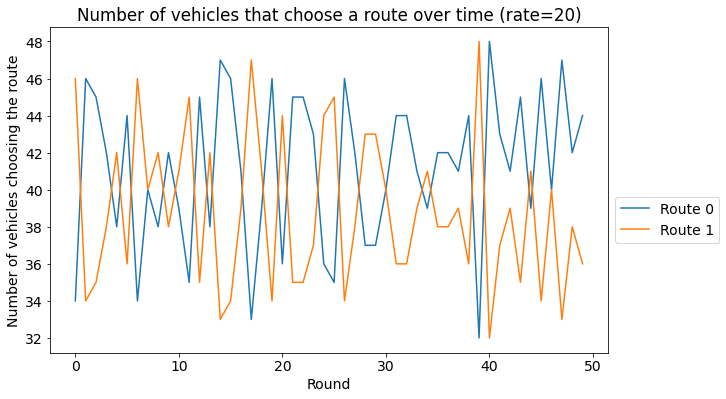

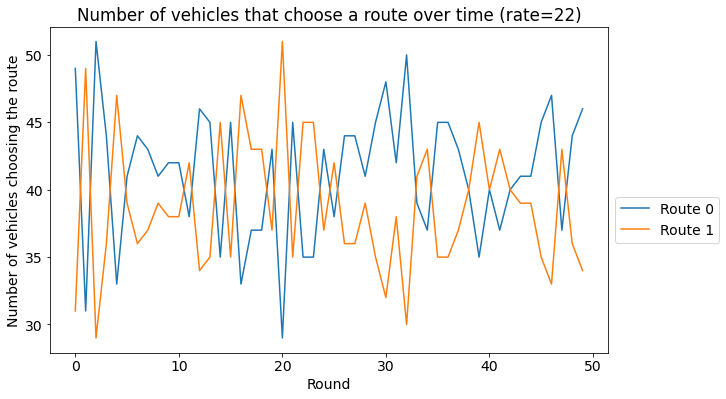

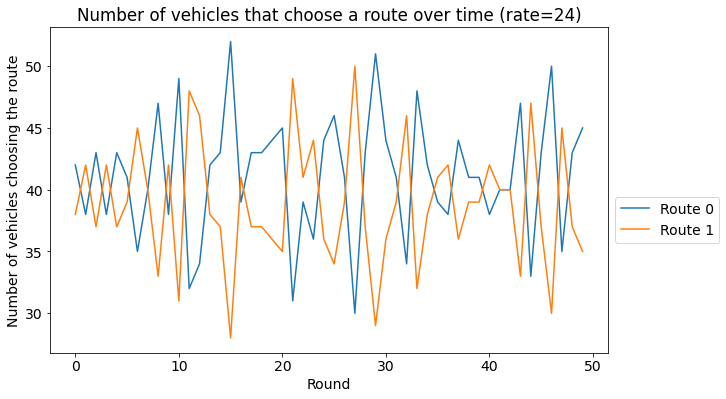

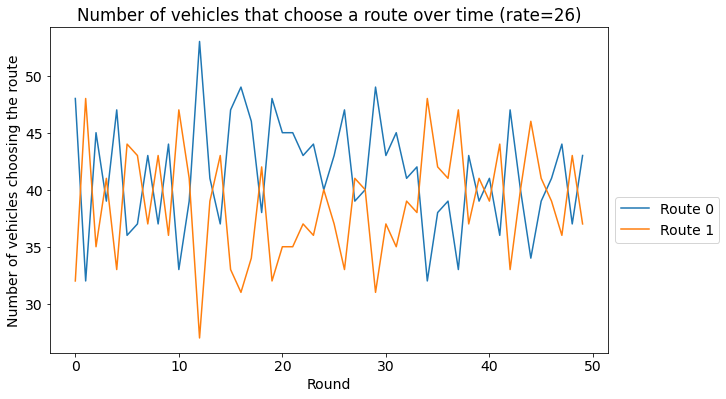

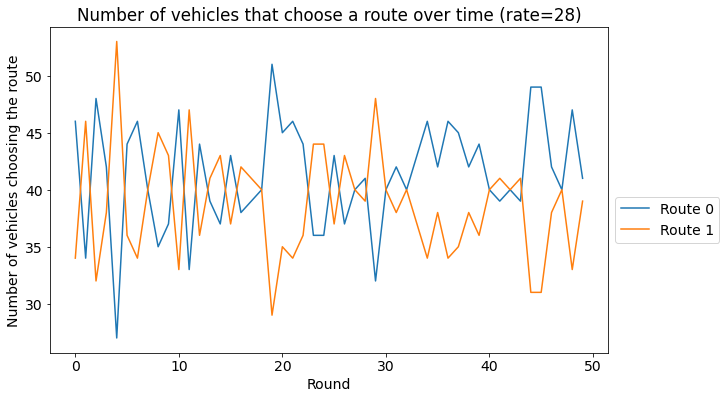

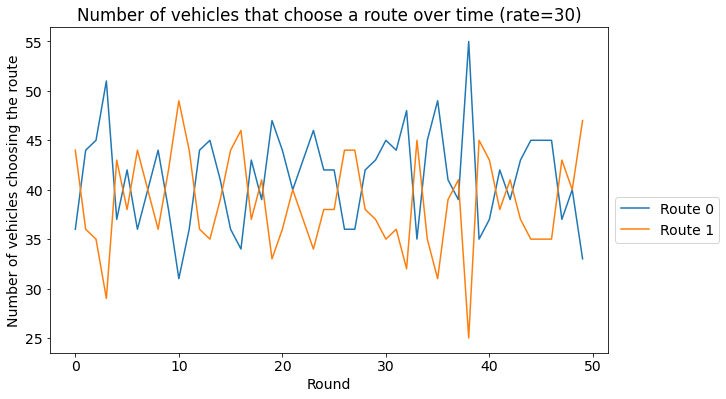

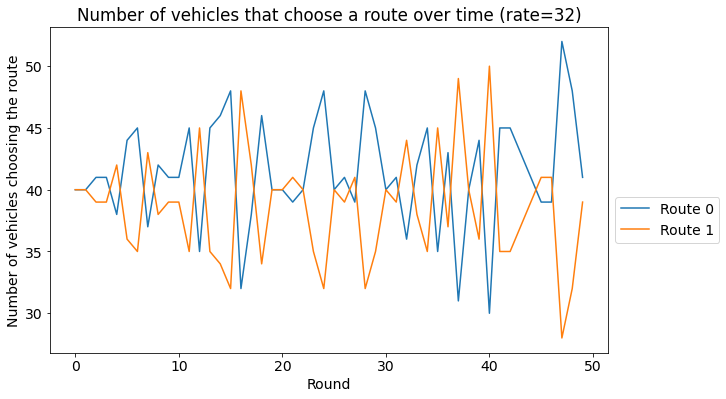

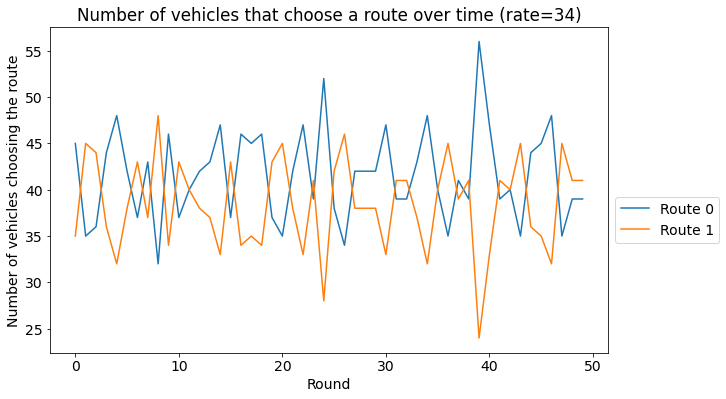

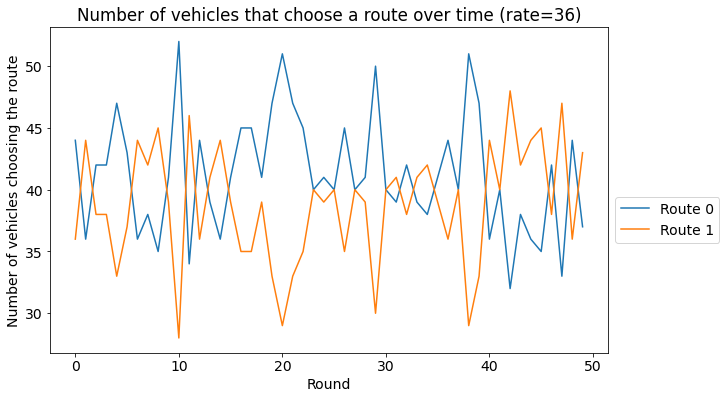

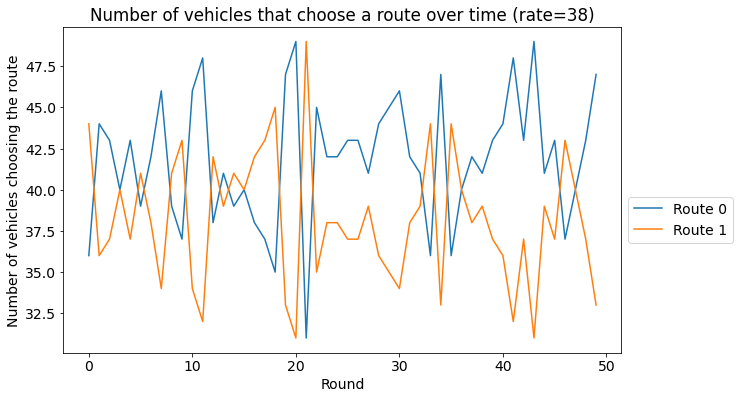

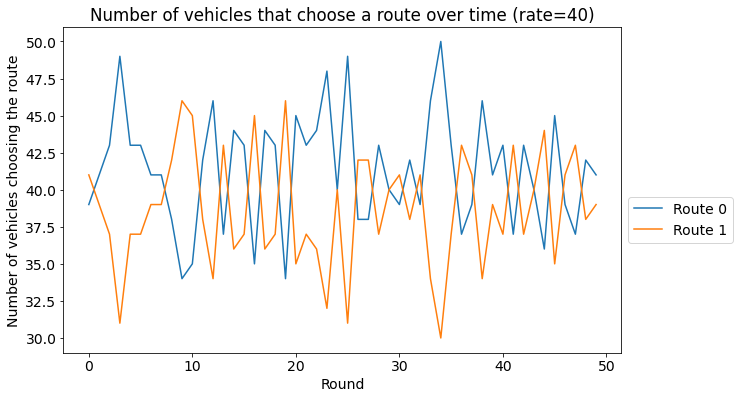

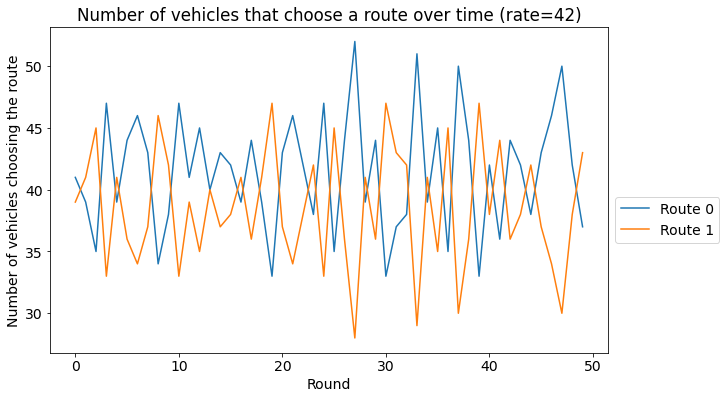

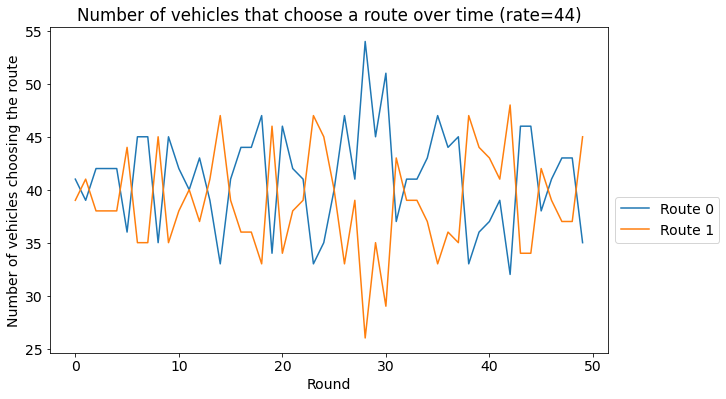

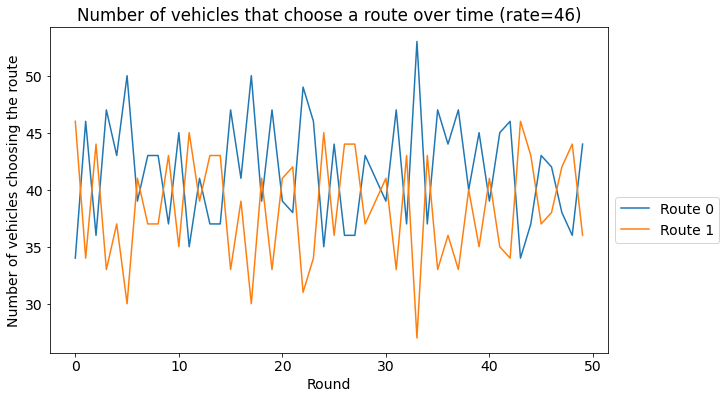

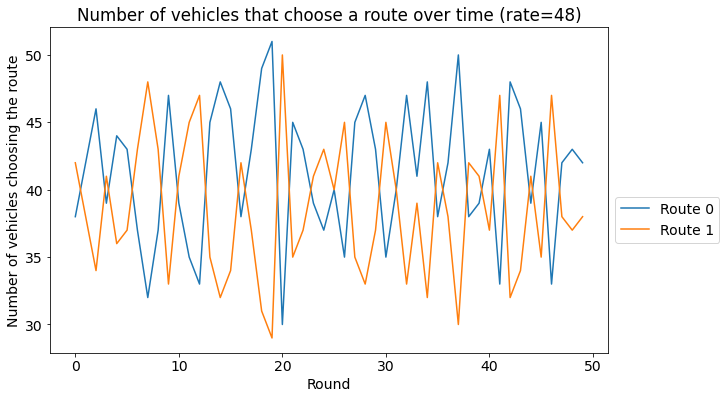

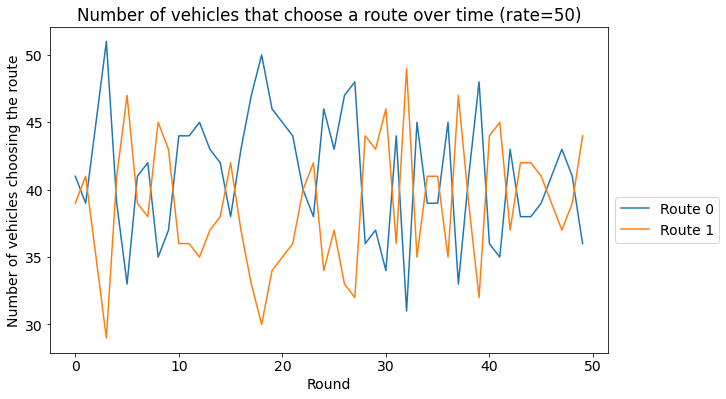

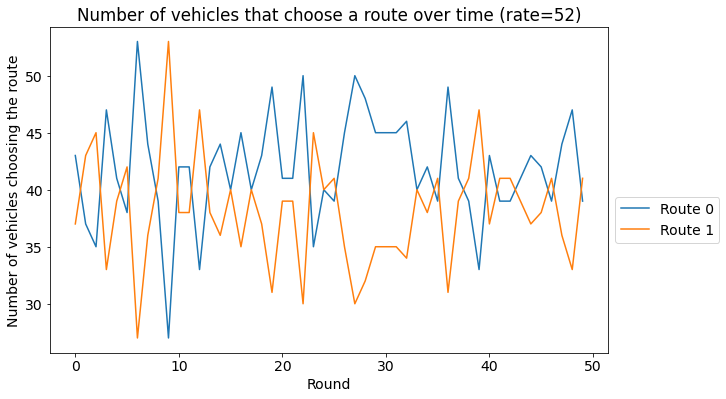

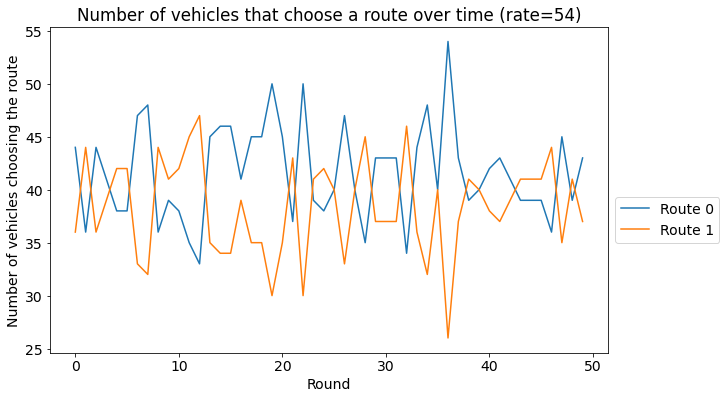

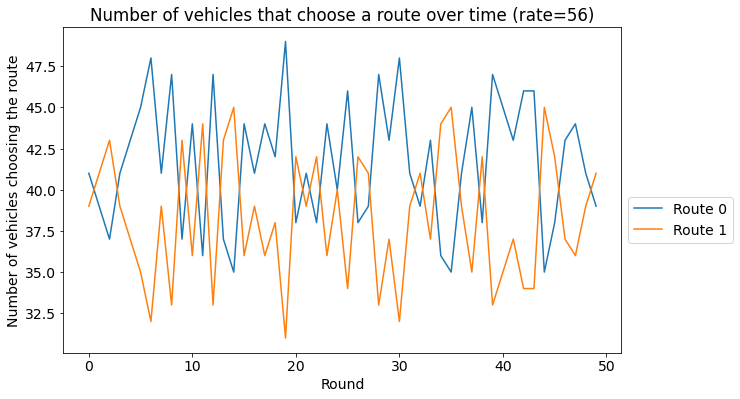

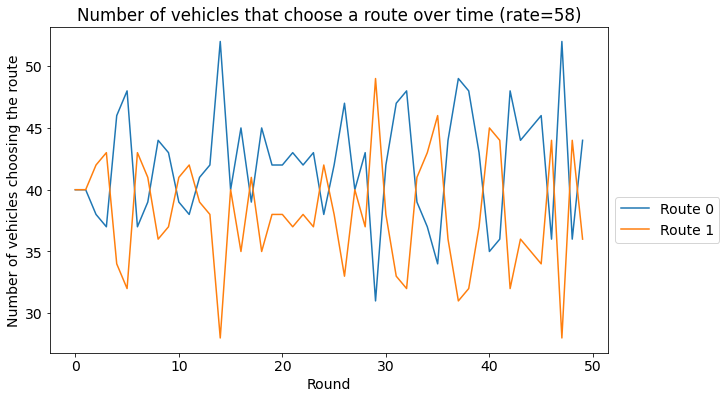

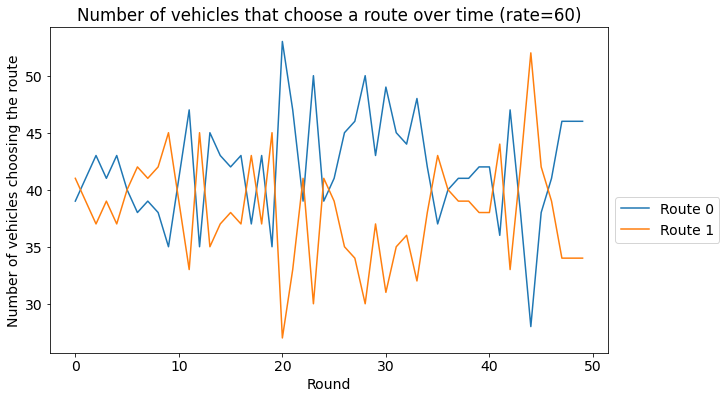

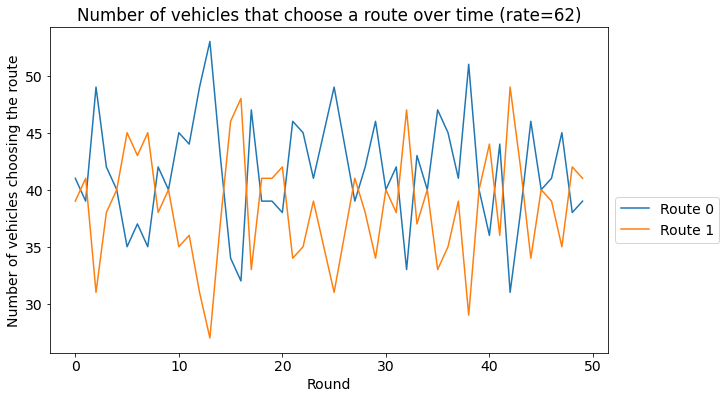

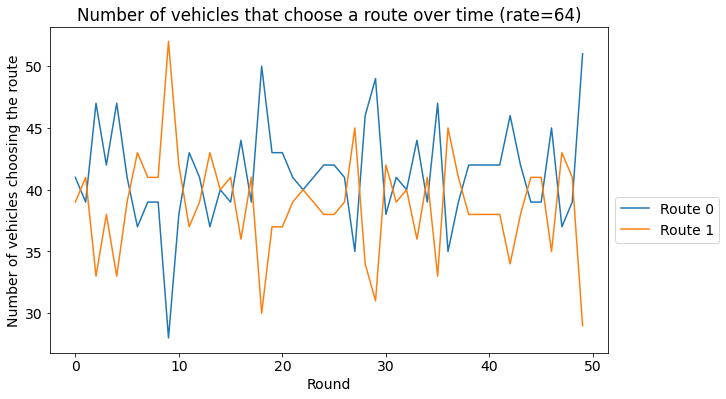

In [34]:
for i in rate_range:
    utility_df = pd.read_csv(f'1.2 No connection/Saved_data/Utility_data/{i}/Round_{rounds}.csv')
    utility_df = preprocess_utility(utility_df)

    fig3, ax3 = plt.subplots(figsize=(10, 6))
    
    route_taken_number(ax3, 
                   fig3, 
                   utility_df, 
                   rounds, 
                   len(sub_routes),
                   i,
#                    save_dir="Route_Chosen_Times.png"
                  )

## - The probabilities of choosing different routes over time

### Zero alpha case

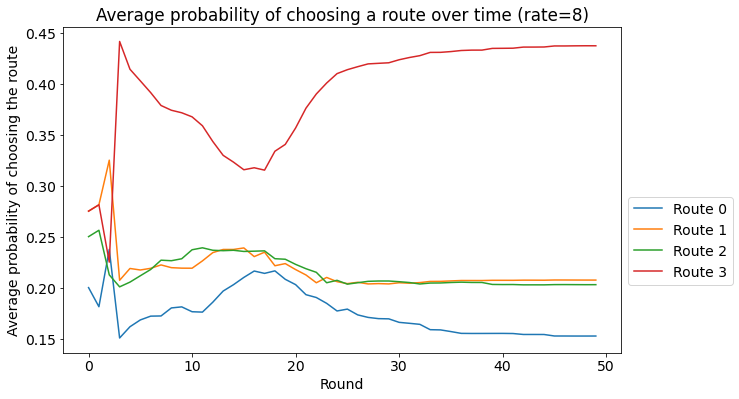

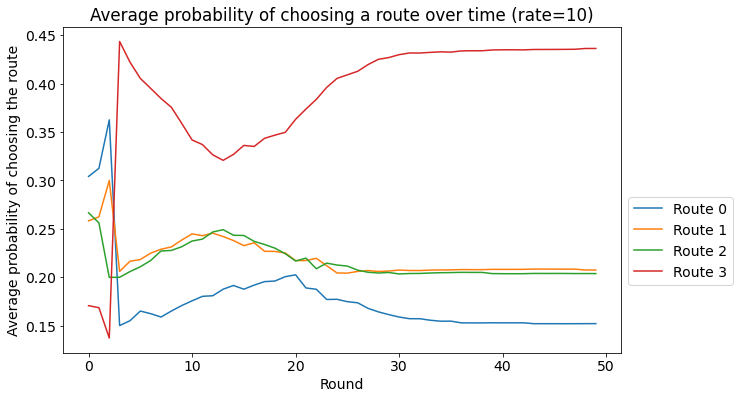

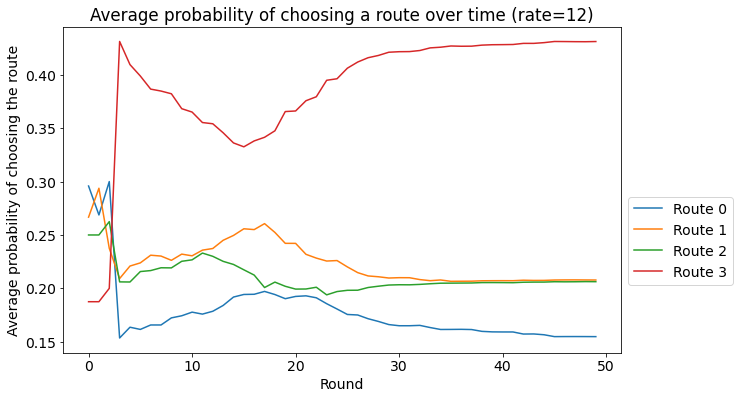

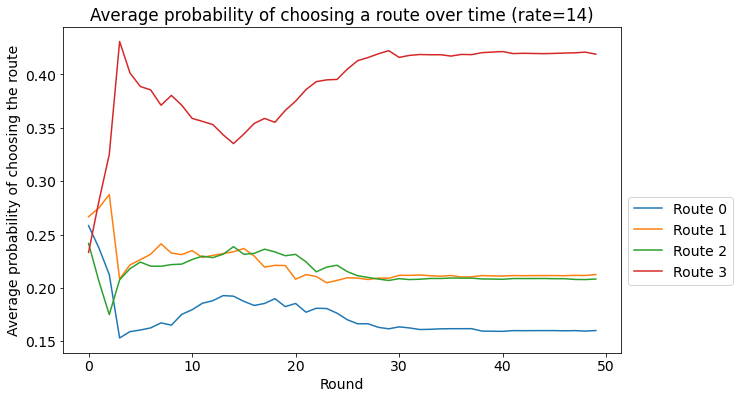

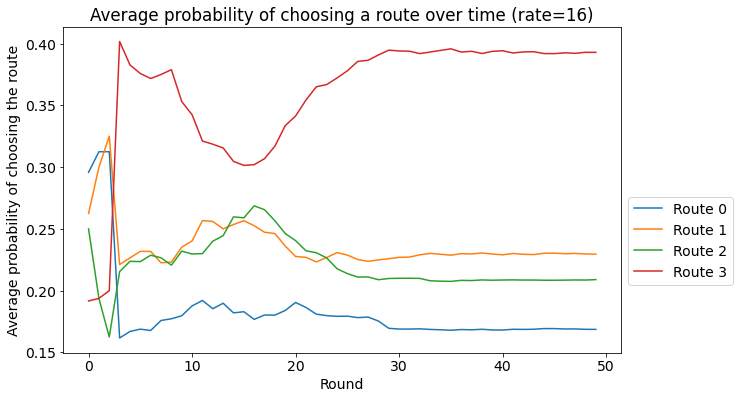

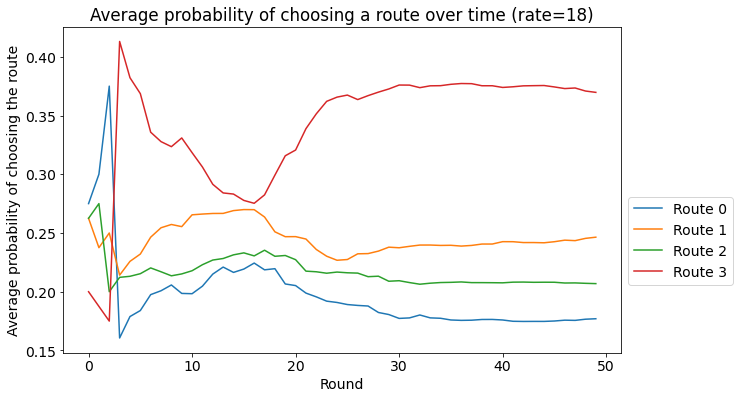

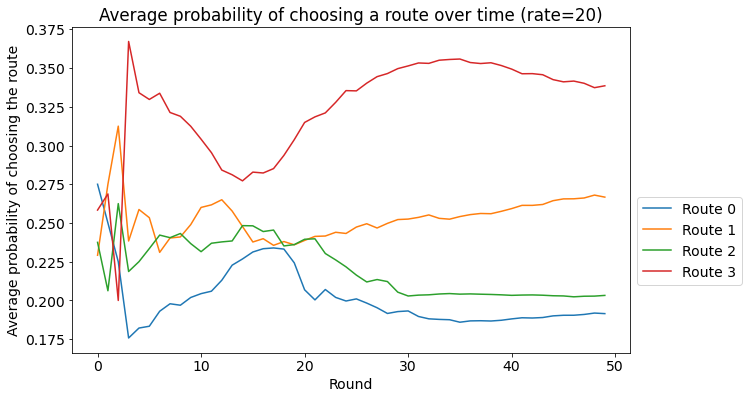

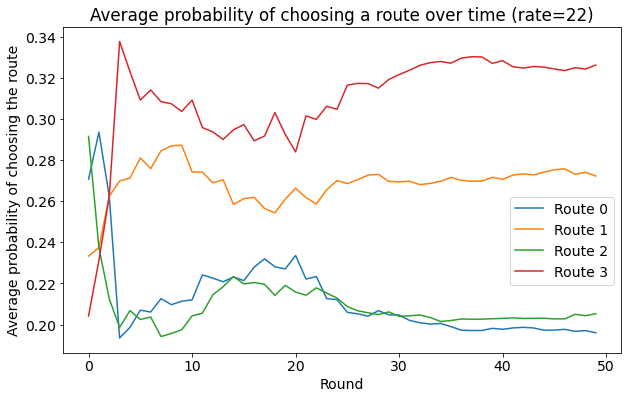

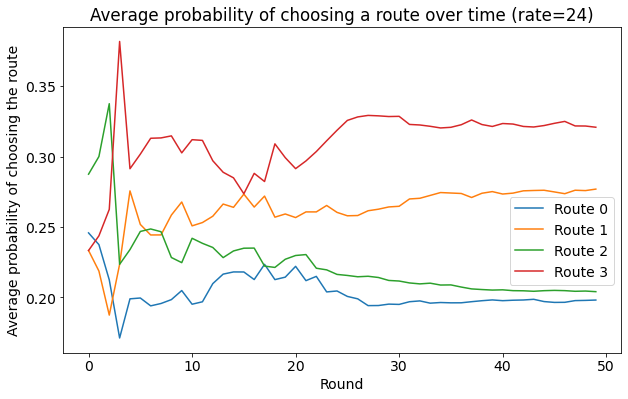

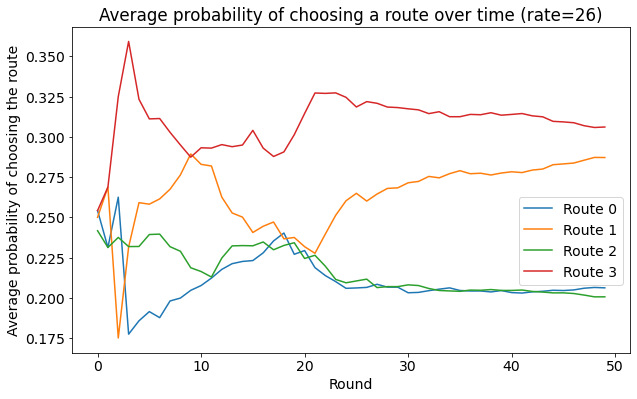

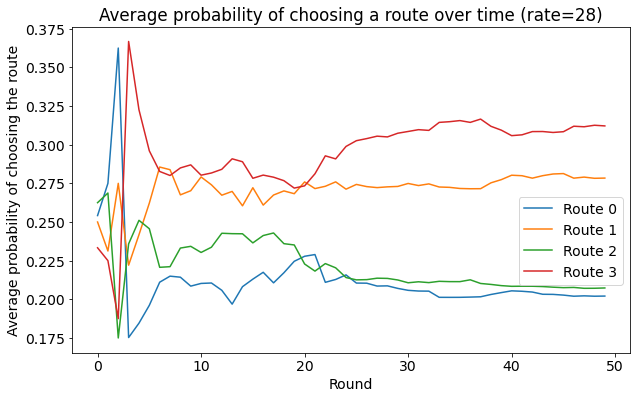

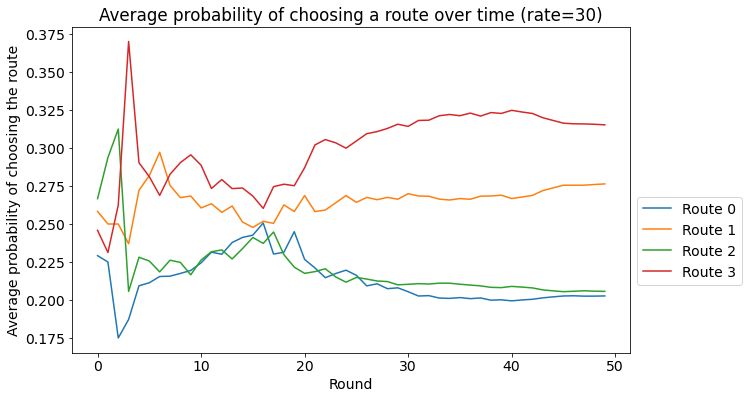

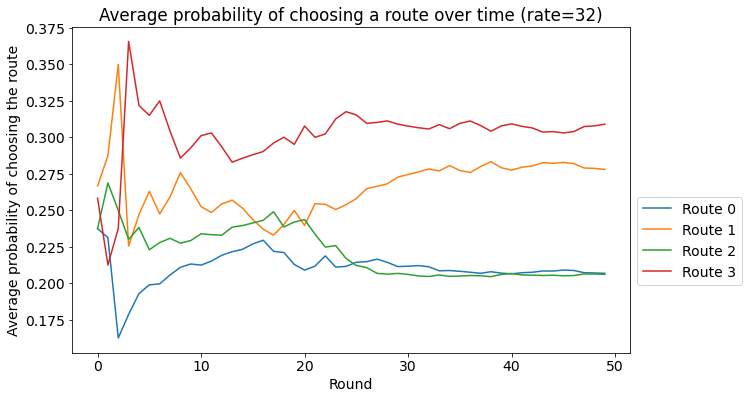

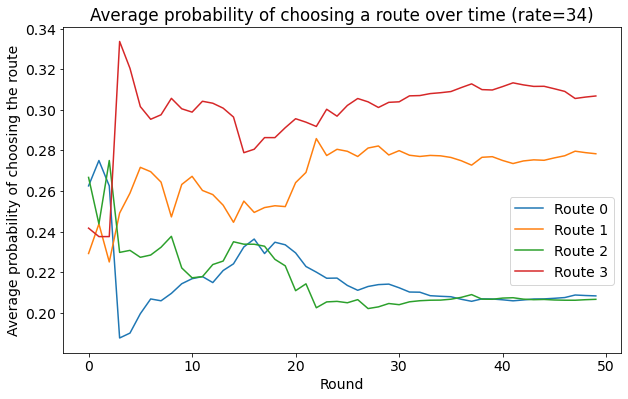

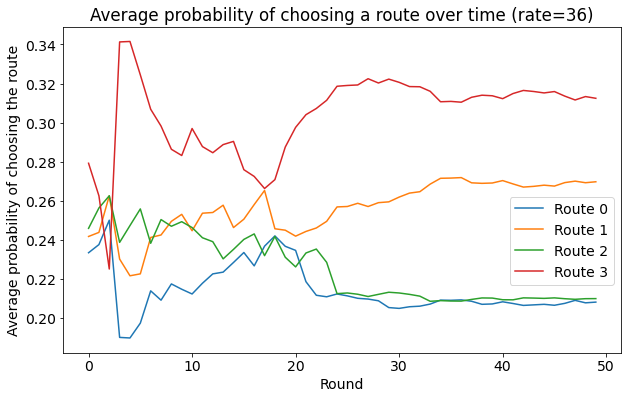

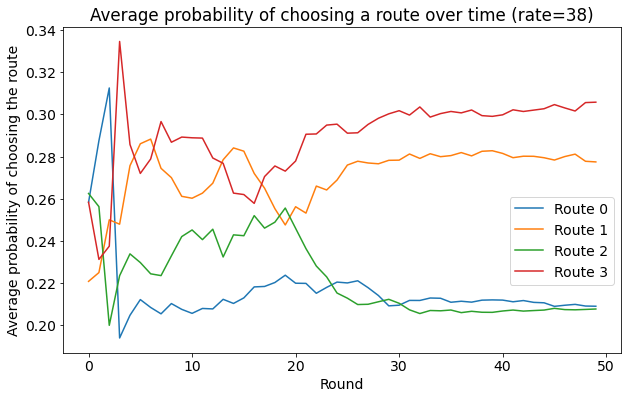

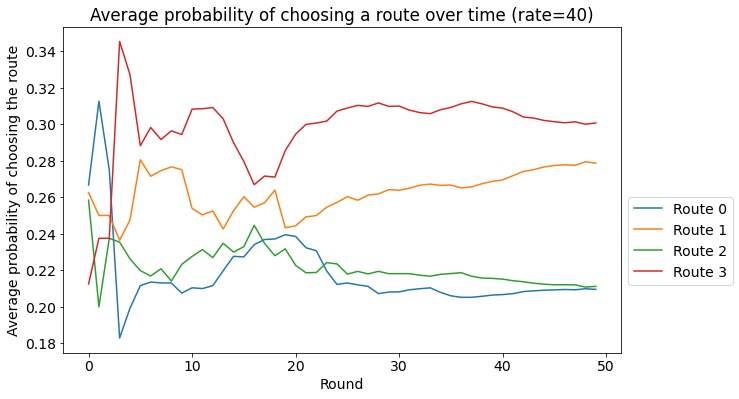

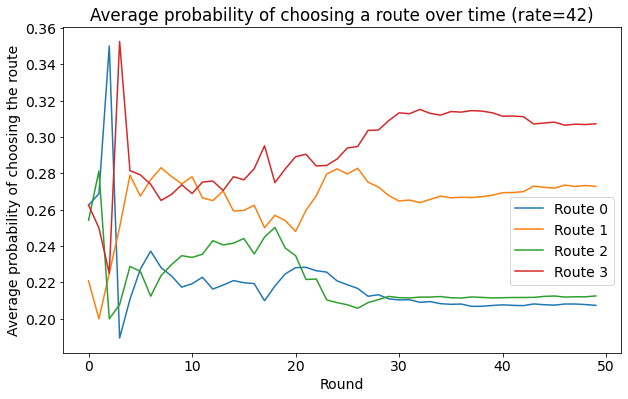

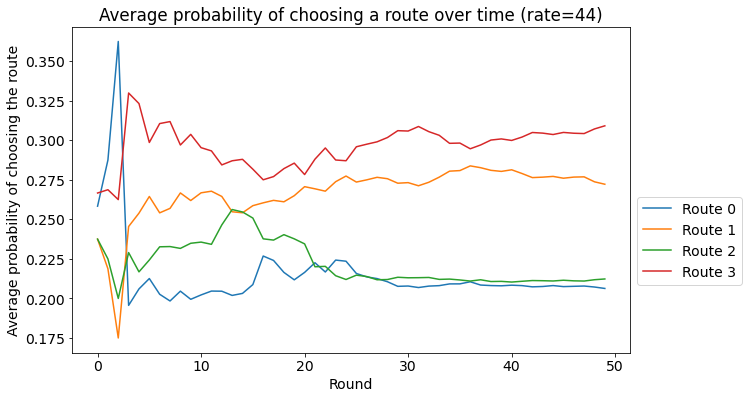

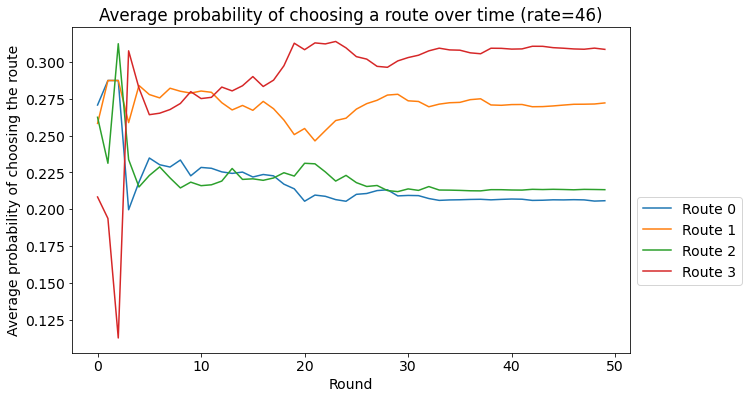

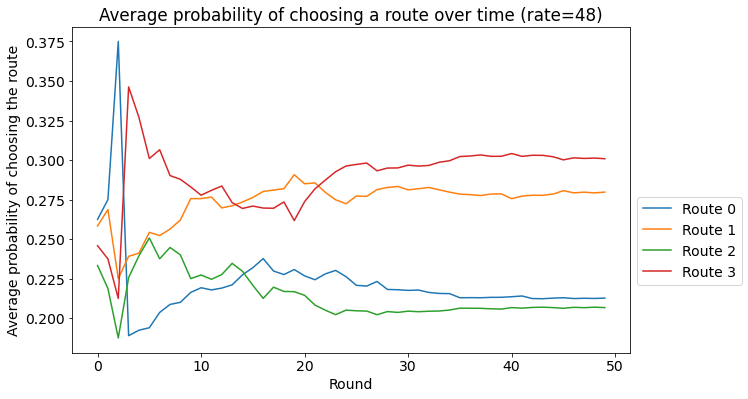

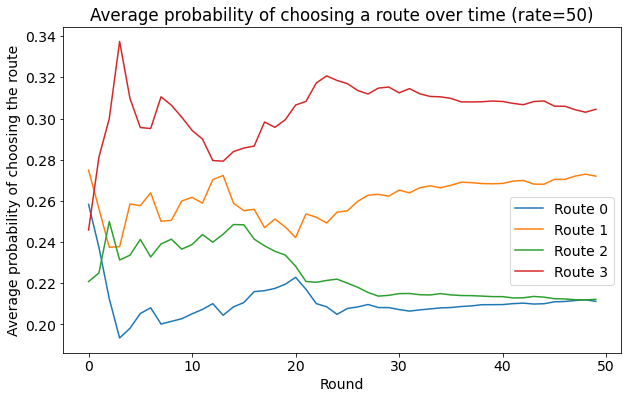

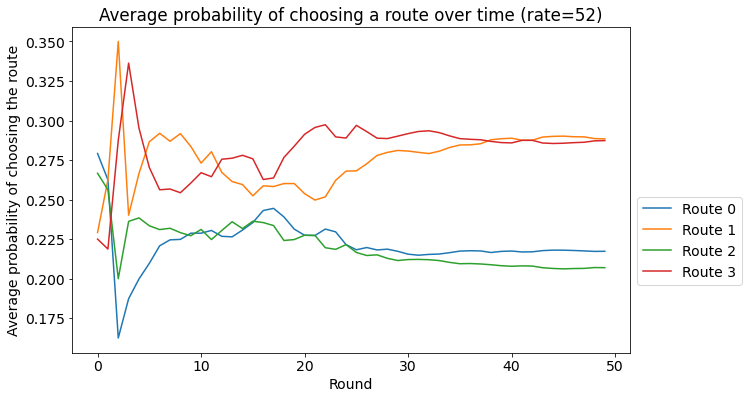

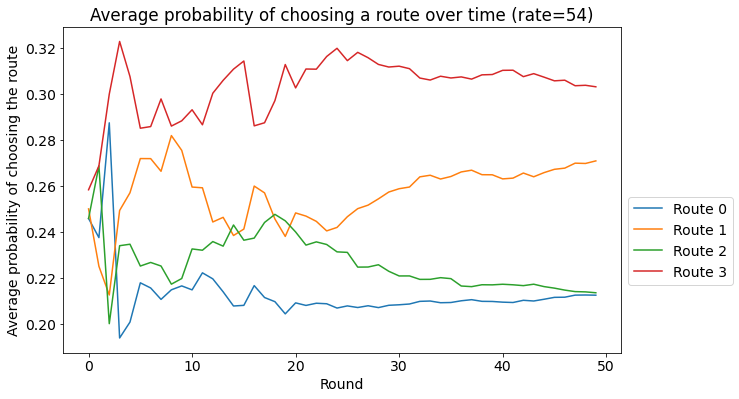

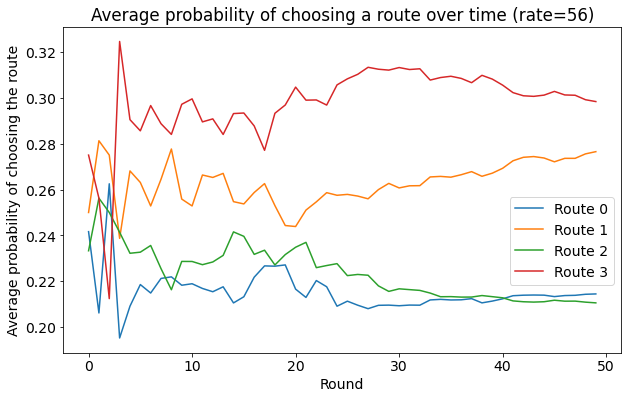

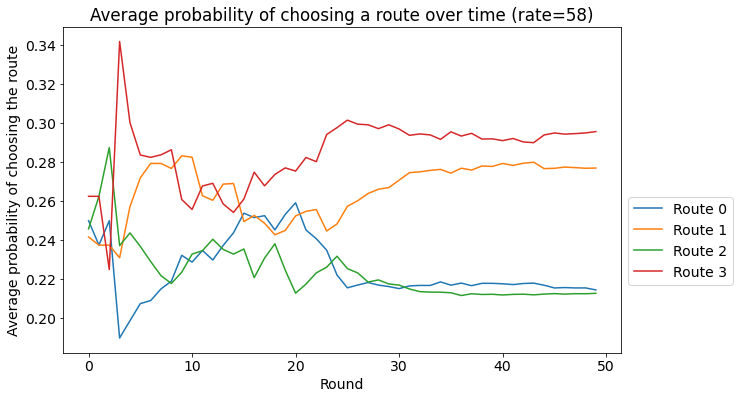

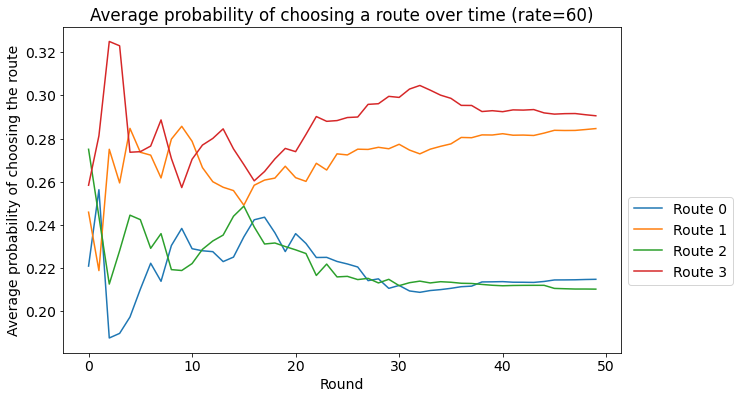

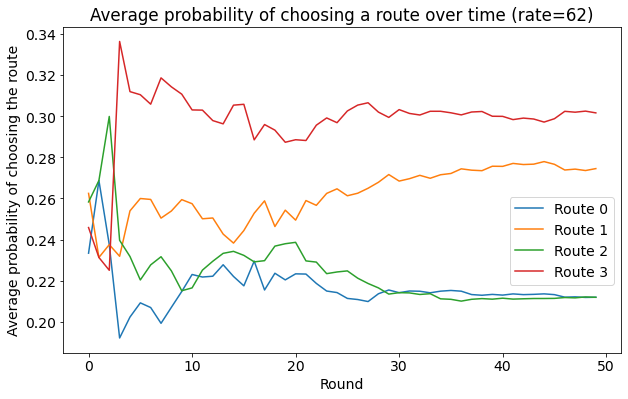

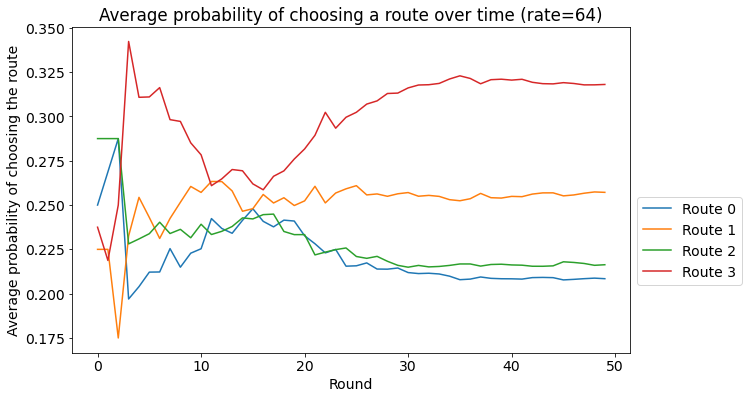

In [44]:
for i in rate_range:
#     utility_df = pd.read_csv(f'1.1 Zero alpha/Saved_data/Utility_data/{i}/Round_{rounds}.csv')
#     utility_df = preprocess_utility(utility_df)

    fig4, ax4 = plt.subplots(figsize=(10, 6))
    
    route_chosen_probability(ax4, 
                         fig4,
                         rounds, 
                         len(all_routes),
                         i,
                         "1.1 Zero alpha",
#                          save_dir="Route_Avg_Prob.png"
                        )

### No connection case

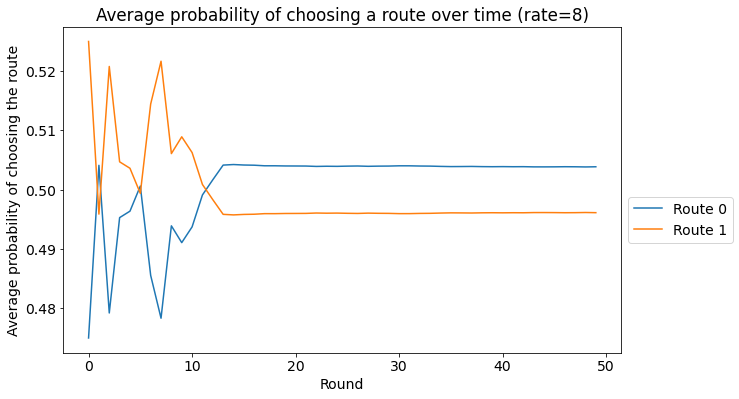

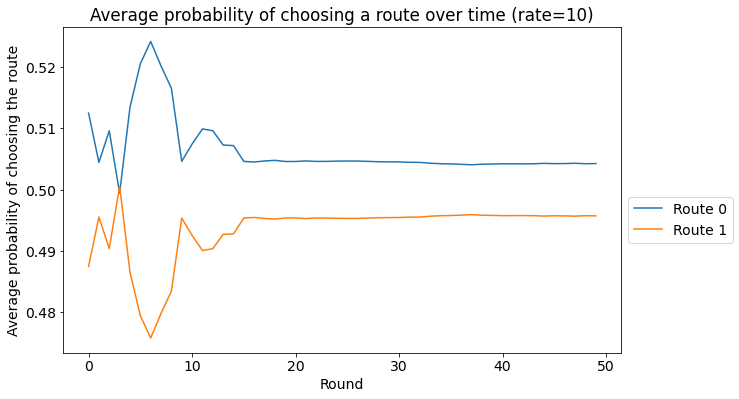

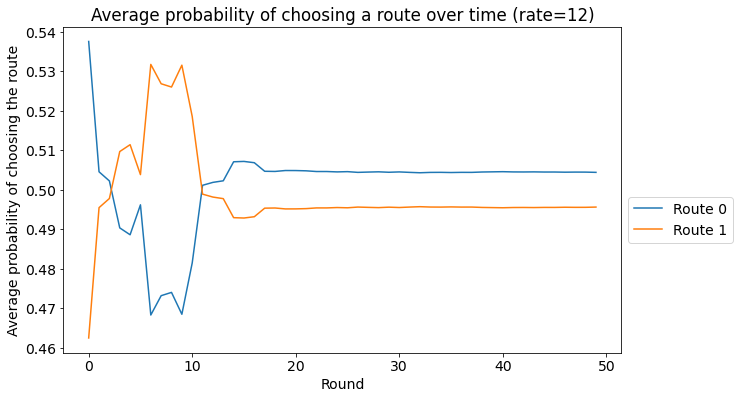

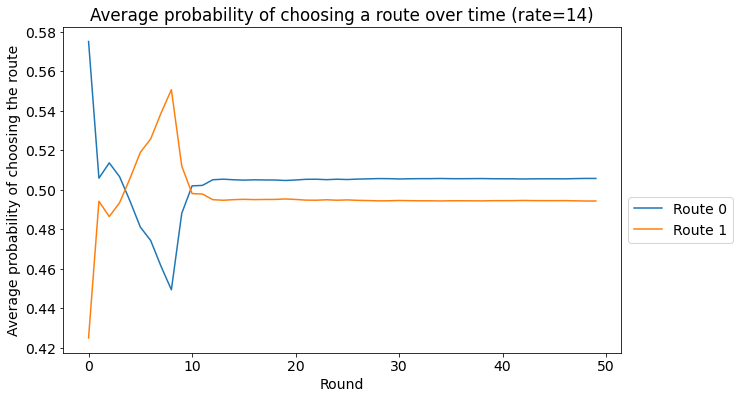

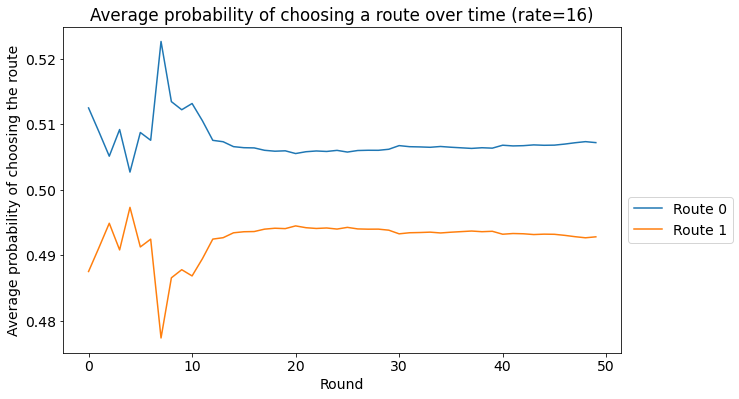

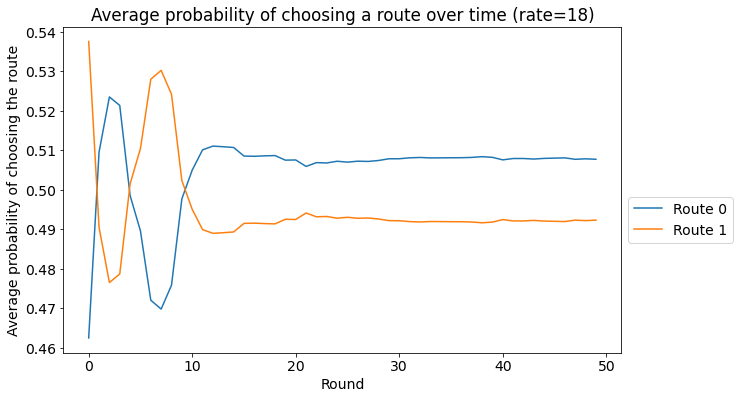

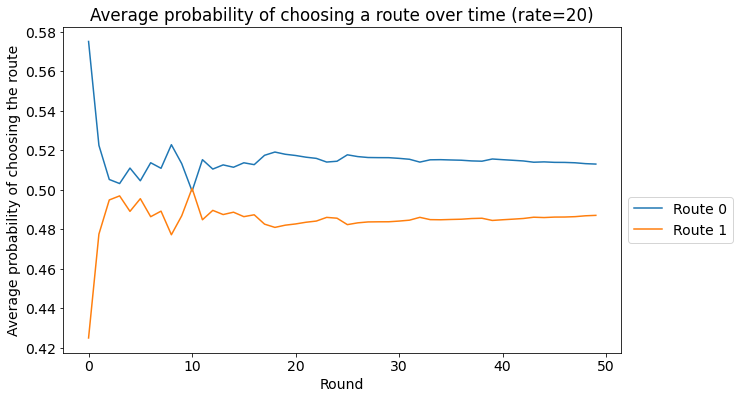

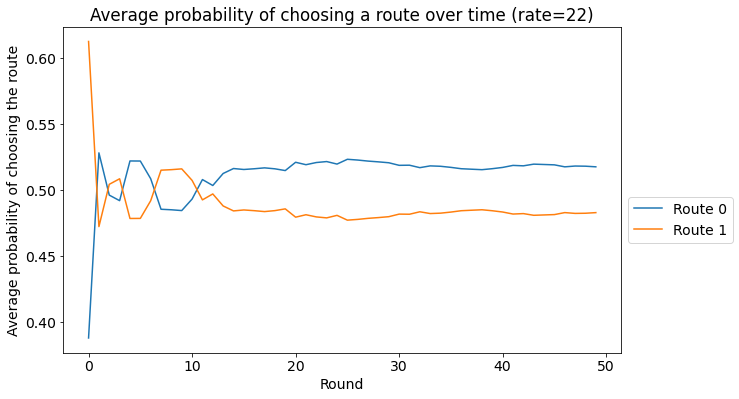

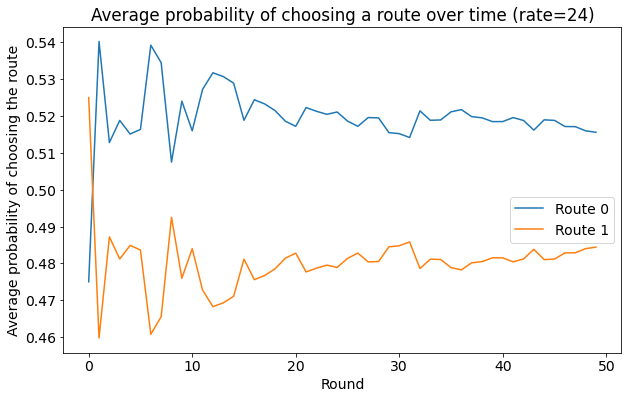

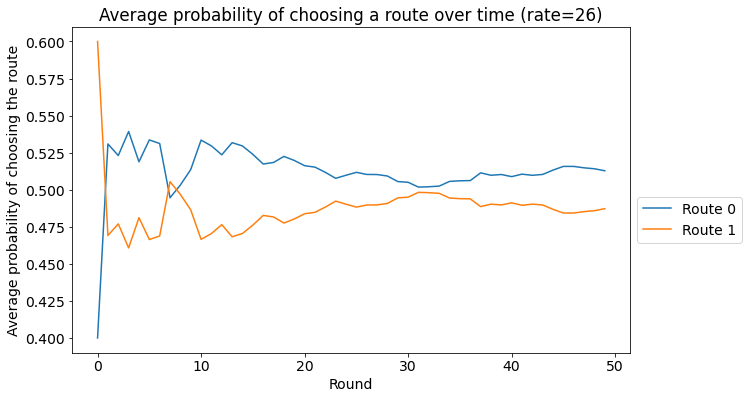

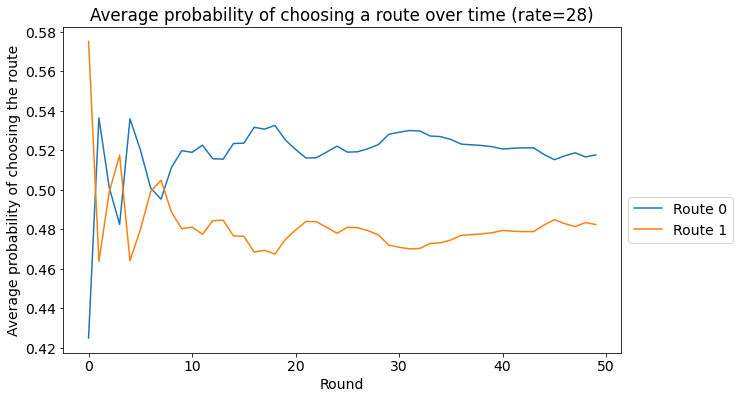

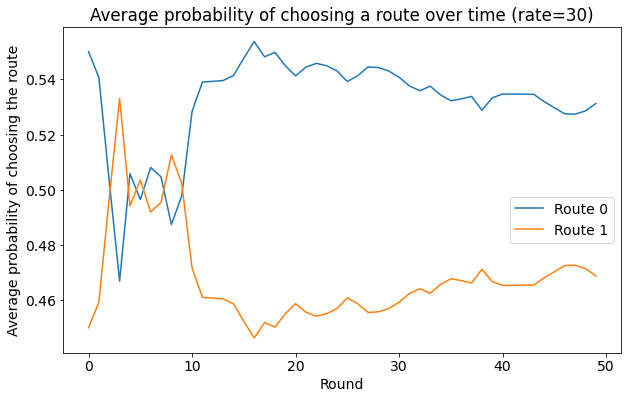

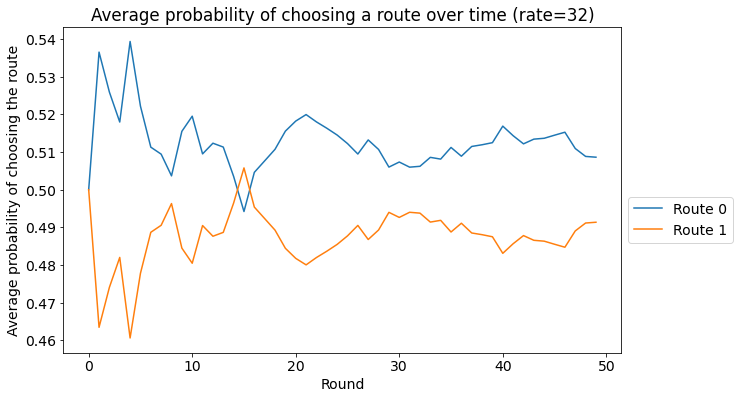

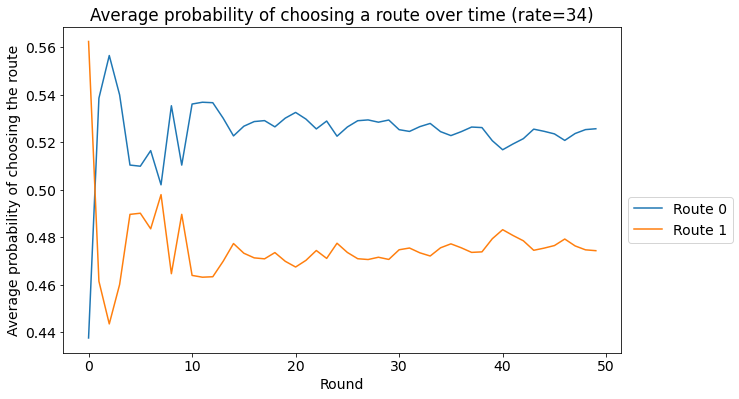

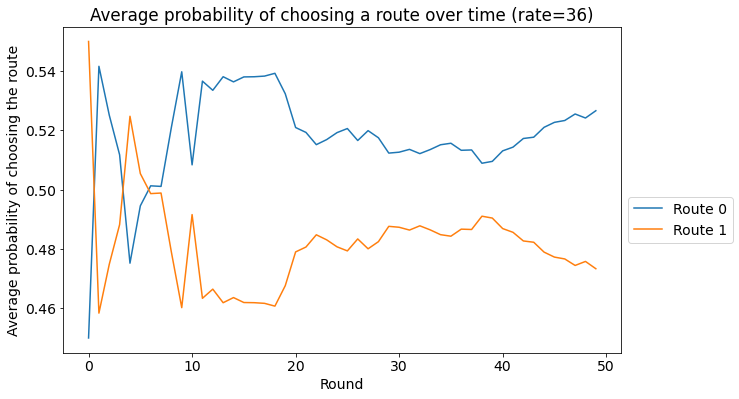

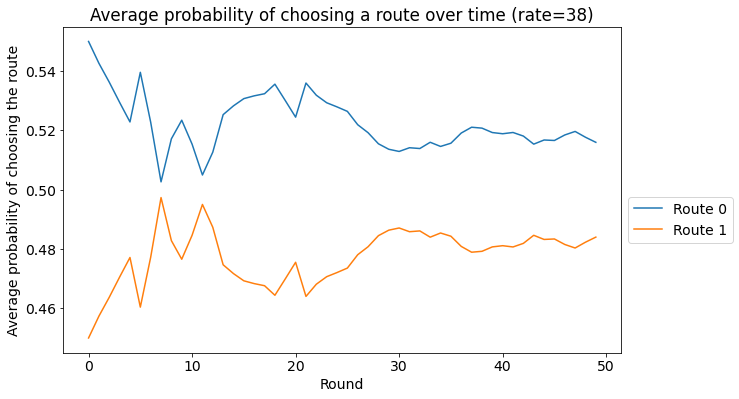

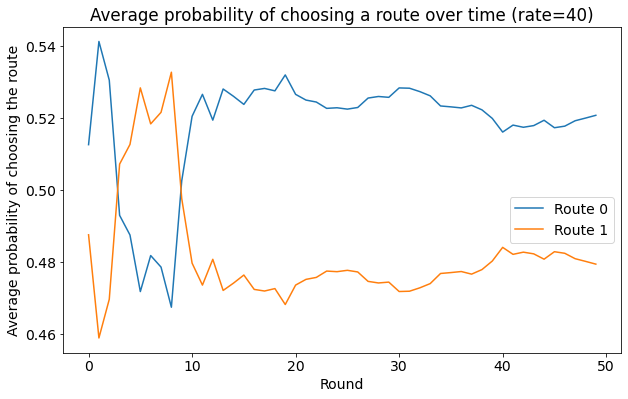

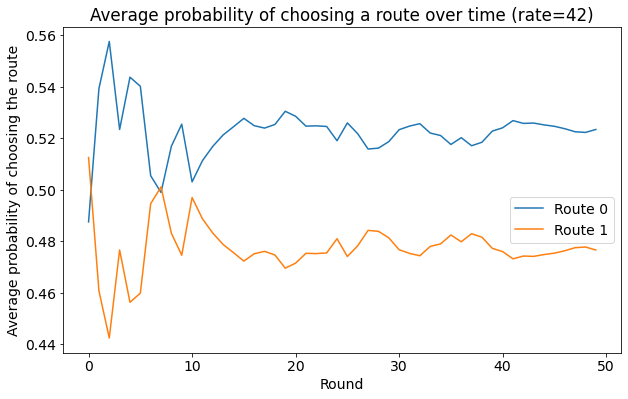

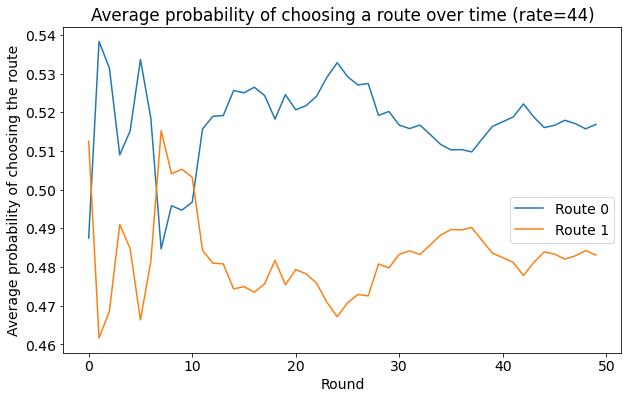

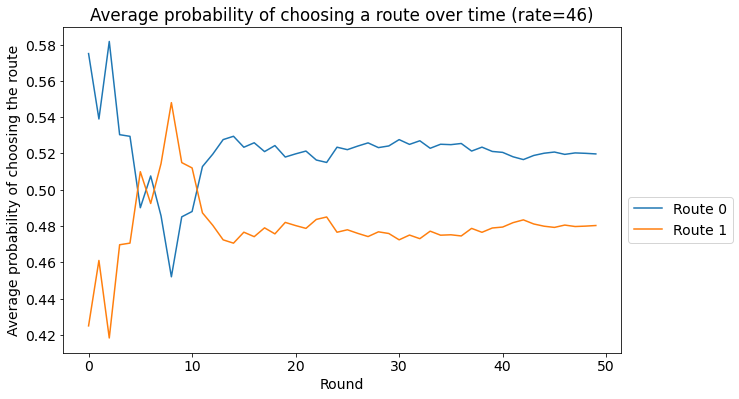

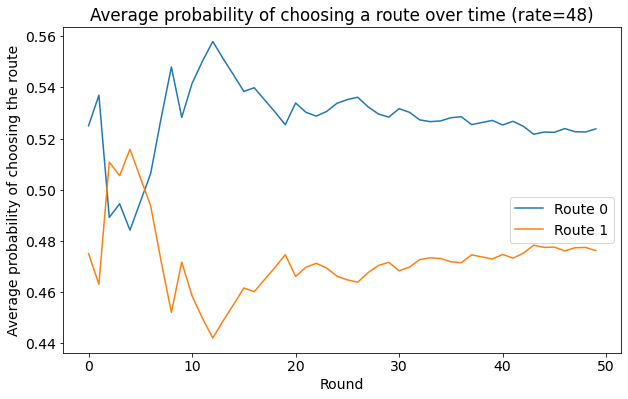

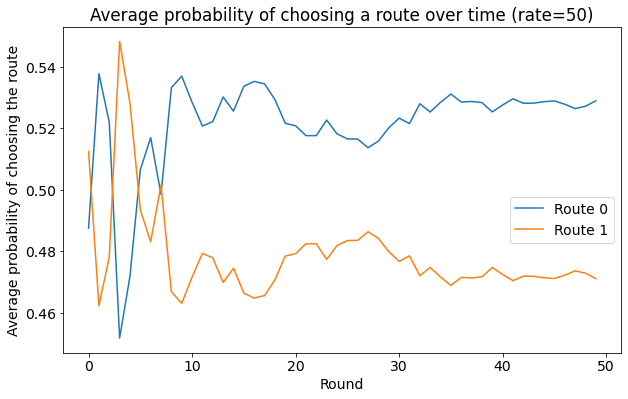

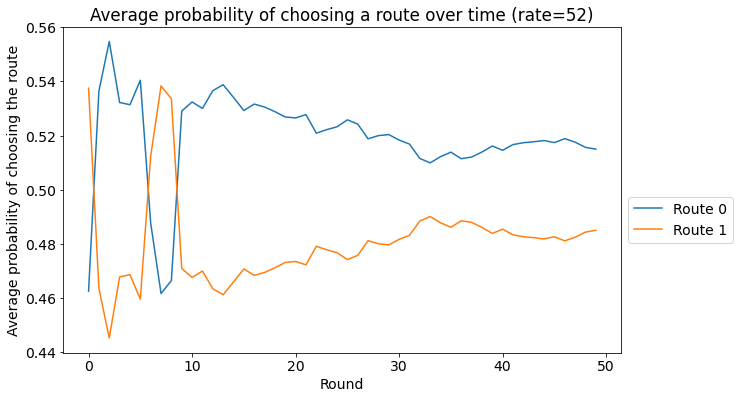

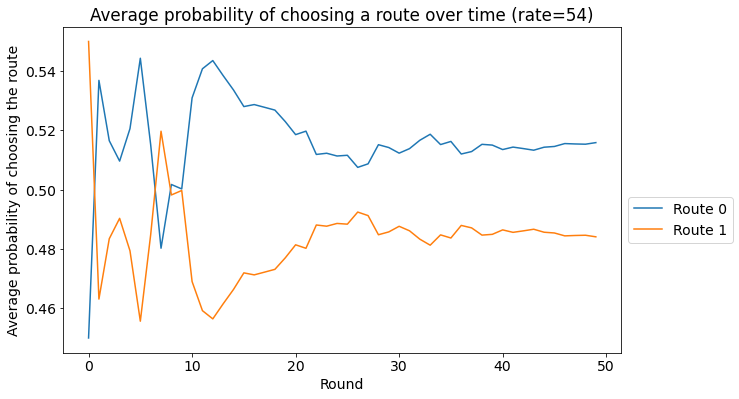

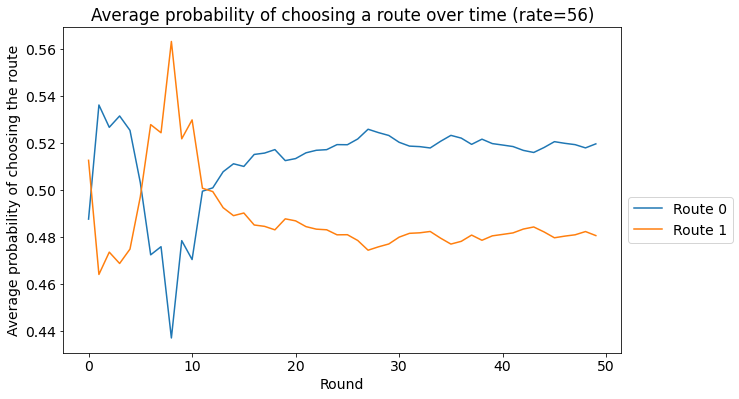

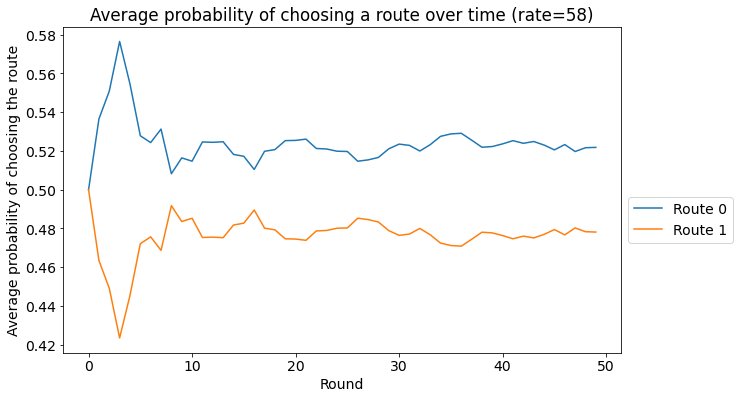

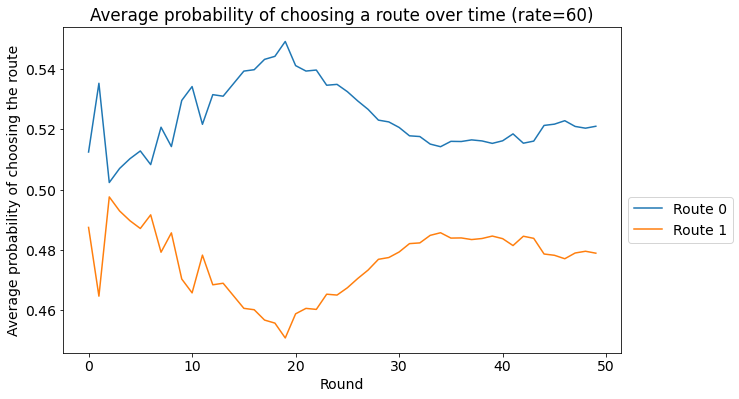

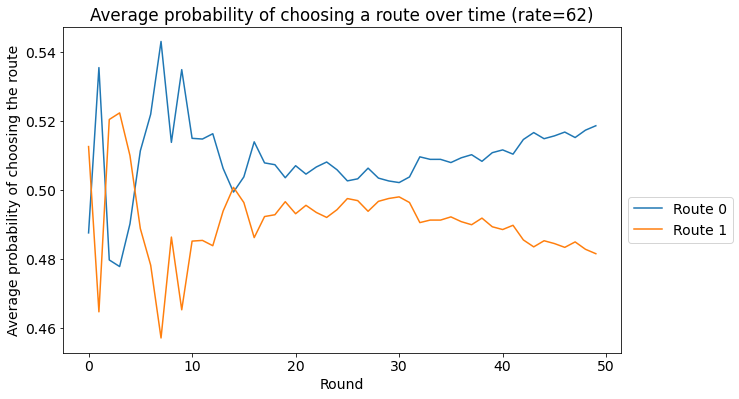

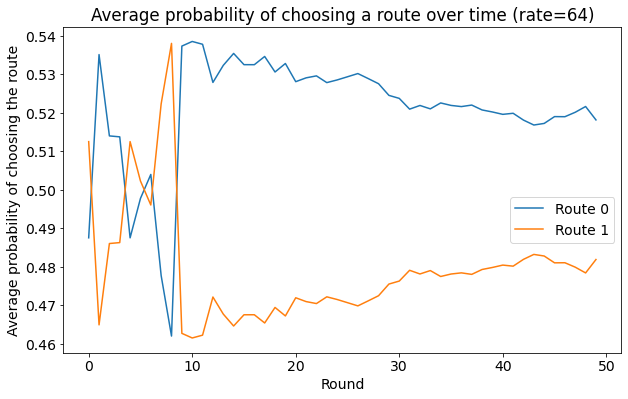

In [48]:
for i in rate_range:
    fig4, ax4 = plt.subplots(figsize=(10, 6))
    
    route_chosen_probability(ax4, 
                         fig4,
                         rounds, 
                         len(sub_routes),
                         i,
                         "1.2 No connection",
#                          save_dir="Route_Avg_Prob.png"
                        )

## - The total time spent of all vehicles in the last few rounds

In [9]:
# Compute the last 15 rounds' average total time spent per round for each vehicle rate when
# there is a middle connection in the topology
avg_times = []
for i in rate_range:
    df = pd.read_csv(f'1.1 Zero alpha/Saved_data/Simulation_records/VehicleRate_{i}_Round_{rounds}.csv')
    avg_time = avg_total_time(df, target_number_of_rounds, rounds)
    avg_times.append(avg_time)

In [10]:
# Compute the last 15 rounds' average total time spent per round for each vehicle rate when
# there is no middle connection in the topology
opt_avg_times = []
for i in rate_range:
    df = pd.read_csv(f'1.2 No connection/Saved_data/Simulation_records/VehicleRate_{i}_Round_{rounds}.csv')
    opt_avg_time = avg_total_time(df, target_number_of_rounds, rounds)
    opt_avg_times.append(opt_avg_time)

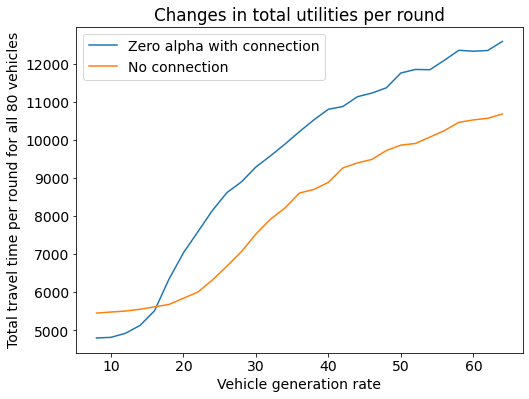

In [21]:
# For each vehicle rate, compare the total time spent on average for each round
plt.plot(rate_range, avg_times, label='Zero alpha with connection')
plt.plot(rate_range, opt_avg_times, label='No connection')

plt.xlabel("Vehicle generation rate")
plt.ylabel("Total travel time per round for all 80 vehicles")
plt.title("Changes in total utilities per round")
plt.legend()
plt.savefig("Change_in_total_travel_time_per_round.png")
plt.show()

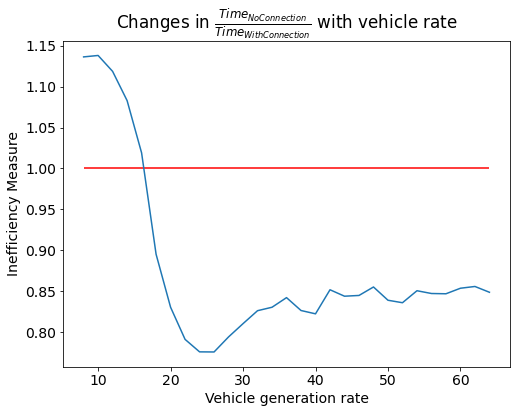

In [12]:
# PoA = [avg_times[i] / opt_avg_times[i] for i in range(len(opt_avg_times))]
# plt.plot(rate_range, PoA)
# plt.hlines(1, 8, 64, color='r')

PoA = [opt_avg_times[i] / avg_times[i] for i in range(len(opt_avg_times))]
plt.plot(rate_range, PoA)
plt.hlines(1, 8, 64, color='r')

plt.xlabel("Vehicle generation rate")
plt.ylabel(r"Inefficiency Measure")
plt.title(r"Changes in $\frac{Time_{NoConnection}}{Time_{WithConnection}}$ with vehicle rate")
# plt.savefig("Changes_in_Inefficiency_with_rate.png")
plt.show()

In [14]:
print(f"The position of the vehicle rate that causes the most "+\
      f"inefficiency is {PoA.index(min(PoA))}, and the corresponding "+\
      f"vehicle rate is {rate_range[PoA.index(min(PoA))]}.")



The position of the vehicle rate that causes the most inefficiency is 9, and the corresponding vehicle rate is 26.


In [20]:
sorted_PoA_idx = sorted(range(len(PoA)), key=lambda k: PoA[k])
[rate_range[sorted_PoA_idx[k]] for k in range(3)]

[26, 24, 22]

In [15]:
slopes = []
for i in range(len(PoA)-1):
    slope = (PoA[i+1] - PoA[i])/2
    slopes.append(slope)
    
print(f"The position of the vehicle rate increases the inefficiency most "+\
      f"rapidly is {slopes.index(max(slopes))}, and the corresponding "+\
      f"vehicle rate is {rate_range[PoA.index(min(PoA))]}.")

In [12]:
rate_range[slopes.index(max(slopes))], PoA[slopes.index(max(slopes))]

(16, 0.9812538809768532)

In [13]:
print(slopes.index(max(slopes)))
PoA[4], PoA[5], slopes[4], slopes[5]

4


(0.9812538809768532,
 1.11711527836916,
 0.06793069869615342,
 0.04358645331699573)

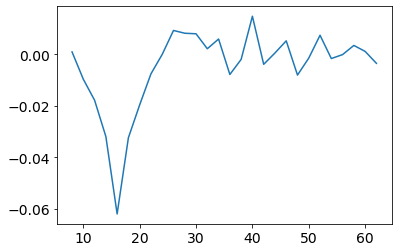

In [105]:
plt.plot(rate_range[:-1], slopes)

## - The total utilities of all vehicles in the last few rounds

### Zero alpha case

In [25]:
utilities_0 = []

for i in rate_range:

    target_number_of_rounds = 15
    total_utilities = total_utility(target_number_of_rounds, 
                                    rounds,
                                    i,
                                    "1.1 Zero alpha"
                                   )
#     print(f"The average total utilities in the last {target_number_of_rounds} rounds is {round(sum(total_utilities)/target_number_of_rounds)}")
    utilities_0.append(sum(total_utilities)/target_number_of_rounds)

### No connection case

In [26]:
utilities_no = []

for i in rate_range:

    target_number_of_rounds = 15
    total_utilities = total_utility(target_number_of_rounds, 
                                    rounds,
                                    i,
                                    "1.2 No connection"
                                   )
#     print(f"The average total utilities in the last {target_number_of_rounds} rounds is {round(sum(total_utilities)/target_number_of_rounds)}")
    utilities_no.append(sum(total_utilities)/target_number_of_rounds)

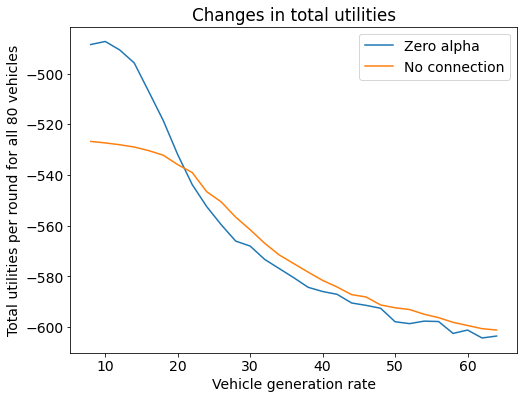

In [30]:
plt.plot(rate_range, utilities_0, label='Zero alpha')
plt.plot(rate_range, utilities_no, label='No connection')
plt.xlabel("Vehicle generation rate")
plt.ylabel("Total utilities per round for all 80 vehicles")
plt.title("Changes in total utilities")
plt.savefig("Change_in_total_utilities_per_round.png")
plt.legend()
plt.show()

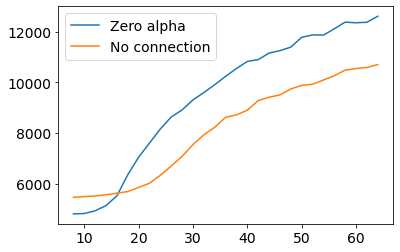

In [76]:
# rate_range[7]
plt.plot(rate_range, avg_times, label='Zero alpha')
plt.plot(rate_range, opt_avg_times, label='No connection')
plt.legend()
plt.xlabel("Vehicle generation rate")
plt.ylabel("Total travel time per round for all 80 vehicles")
# plt.savefig("Change_in_total_travel_time_per_round.png")
plt.show()

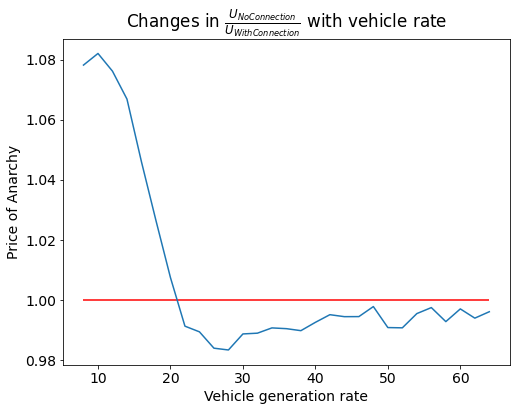

In [32]:
# p = [utilities_no[i] > utilities_0[i] for i in range(len(utilities_no))]
# p

PoA2 = [1/(utilities_0[i] / utilities_no[i]) for i in range(len(utilities_0))]
plt.plot(rate_range, PoA2)
plt.hlines(1, 8, 64, color='r')
plt.xlabel("Vehicle generation rate")
plt.ylabel(r"Price of Anarchy")
plt.title(r"Changes in $\frac{U_{NoConnection}}{U_{WithConnection}}$ with vehicle rate")
plt.savefig("Changes_in_PoA_utility_with_rate.png")

plt.show()

In [ ]:
# PoA2 reaches above 1 at PoA2[7], but slope is highest at PoA2[3]

In [87]:
PoA2[8]

1.0107445077382036

In [97]:
# PoA2
slopes2 = []
for i in range(len(PoA2)-1):
    slope = (PoA2[i+1] - PoA2[i])/2
    slopes2.append(slope)

In [99]:
# slopes2[8]
PoA2.index(min(PoA2))

10

In [100]:
rate_range[10]

28

10

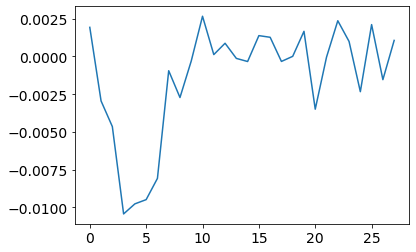

In [101]:
plt.plot(slopes2)
slopes2.index(max(slopes2))

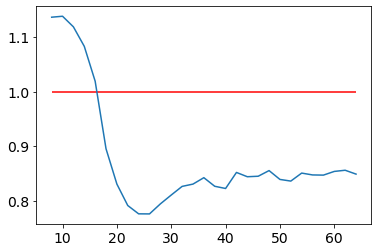

In [96]:
PoA = [opt_avg_times[i] / avg_times[i] for i in range(len(opt_avg_times))]
plt.plot(rate_range, PoA)
plt.hlines(1, 8, 64, color='r')